In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
import pickle
import numpy as np
import pandas as pd

from scipy.interpolate import RegularGridInterpolator

from scipy.stats import chi2
from scipy.special import erfinv
from scipy.optimize import fmin_l_bfgs_b
from matplotlib.colors import LogNorm

from settings import *
from tools import get_mids
from aeff_calculations import energy_smearing


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [539]:
import seaborn as sns

matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]


In [4]:
print(LIVETIME)
print(GAMMA_ASTRO)
print(PHI_ASTRO)


315567360.0
2.28
1.44e-18


# Get the effective areas based on "alternative_plenum_aeff.ipynb"

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = get_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi * 2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")


40 log_10(energy) bins
50 declination bins


### here, we use "Plenum-1" with 10yr IceCube and 10yr PLENUM with IceCube
= baseline PLENUM + 10yr IceCube
### and "Plenum-2" with 10yr IceCube and 10yr PLENUM with GEN2
= baseline PLENUM (includes 10yr IceCube) + 10yr GEN2


# Background

In [7]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))


# Icecube energy x sindec
## comparison to diffuse (only northern) should yield ~600k events, ~2700 astro for a livetime of 10 years

In [10]:
from aeff_calculations import aeff_eval_e_sd
from astro_flux import *


In [13]:
# check
for det in ["IceCube", "Plenum-1"]:
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[det], sindec_width, ewidth, ra_width) * LIVETIME
    )
    astro_ev = astro_flux(
        "powerlaw", aeff_factor, emids, E_NORM, GAMMA_ASTRO, PHI_ASTRO_FACTOR
    )
    atm_ev = atmo_background(aeff_factor, spl_vals)

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))


IceCube
conv events: 673755.3335225435
astro events: 2338.1754666194474
Plenum-1
conv events: 2711814.5071733757
astro events: 9348.83835710726


# Energy smearing with KDE

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

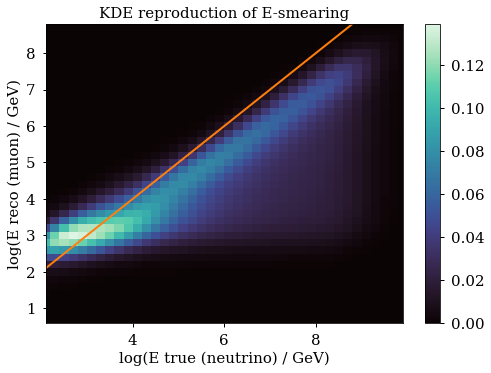

In [17]:
# new energy bins for smeared energy
ebins_sm = np.arange(0.5, 9, 0.2)
e_reco_mids = get_mids(ebins_sm)
# log_emids are the same as for effective area binning
egrid_true, egrid_reco = np.meshgrid(log_emids, e_reco_mids)

plt.grid(False)
plt.pcolormesh(egrid_true, egrid_reco, kvals)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(egrid_reco), np.max(egrid_reco))
plt.xlim(np.min(egrid_true), np.max(egrid_true))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


# Plot exemplary astro_flux shapes with baseline values from shape_params

In [18]:
def plot_spectrum(energy, events, labels, title, f, ax, **kwargs):
    ls = kwargs.pop("ls", ["-"] * len(events))
    color = kwargs.pop("color", [None] * len(events))
    ylim = kwargs.pop("ylim", (0.1, 3e4))
    xlim = kwargs.pop("xlim", (1.8, 9))
    ylabel = kwargs.pop("ylabel", r"# events")
    xlabel = kwargs.pop("xlabel", r"$E_{\mu \, \rm reco}$/GeV")

    for i, (ev, lab) in enumerate(zip(events, labels)):
        ax.plot(
            energy,
            ev,
            drawstyle="steps-mid",
            label=lab,
            ls=ls[i],
            color=color[i],
        )
    ax.legend()
    ax.set_title(title)
    ax.set_yscale("log")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    f.tight_layout()
    return f, ax


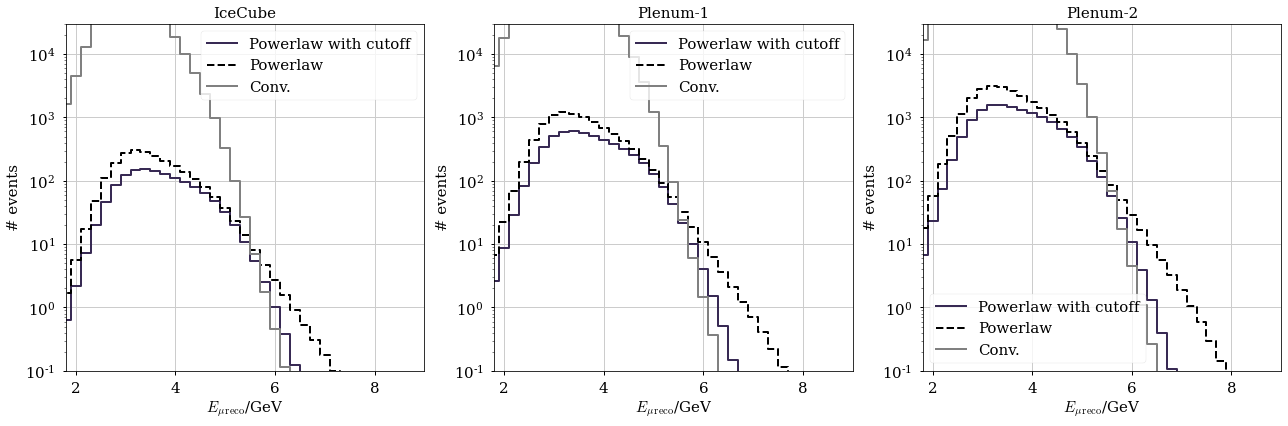

In [20]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    events = [
        np.sum(
            astro_flux(
                "powerlaw cutoff",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw with cutoff"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                "powerlaw",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0),
    ]
    plot_labels = ["Powerlaw with cutoff", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    plot_spectrum(
        e_reco_mids, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color
    )
plt.show()


### Expected astro events with energy smearing

Text(0, 0.5, '$\\sin(\\delta)$')

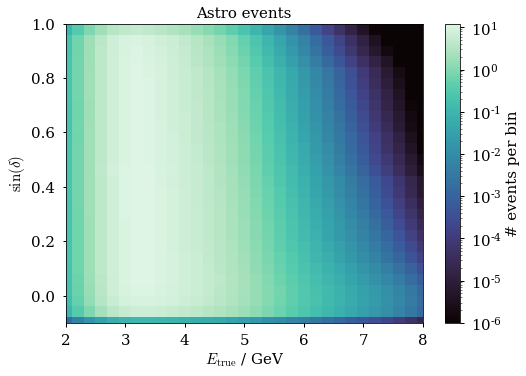

In [34]:
aeff_factor = (
    aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width) * LIVETIME
)
astro_ev = astro_flux(
    "powerlaw", aeff_factor, emids, E_NORM, GAMMA_ASTRO, PHI_ASTRO_FACTOR
)

f, ax = plt.subplots()
plt.grid(False)
im = ax.pcolormesh(ebins_sm, sindec_bins, astro_ev, norm=LogNorm(vmin=1E-6))
cb = plt.colorbar(im, ax=ax)
cb.set_label("# events per bin")
ax.set_ylim(-0.1, 1)
ax.set_xlim(2, 8)
ax.set_title("Astro events")
ax.set_xlabel(r"$E_{\rm true}$ / GeV")
ax.set_ylabel(r"$\sin(\delta)$")


# Test event numbers

## full sky

In [35]:
aeff_factor = (
    aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width) * LIVETIME
)
astro_ev = astro_flux(
    "powerlaw",
    aeff_factor,
    emids,
    E_NORM,
    GAMMA_ASTRO,
    PHI_ASTRO_FACTOR,
    smear_energy=False,
)
print("original sum astro:", np.sum(astro_ev))
print(
    "smeared sum astro:",
    np.sum(energy_smearing(normed_kvals, astro_ev)),
    "(should be numerically the same)",
)


original sum astro: 2338.175466619447
smeared sum astro: 2338.1754666194474 (should be numerically the same)


# NGC 1068

In [36]:
# find the right lower bin boundary/ bin index for NGC1068's declination
ngc_bin_index = np.digitize(np.sin(ngc1068.dec.rad), sindec_bins)
# livetime of 10yr PS data
lt_10yr = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600
# livetime of diffuse NT data with KDE method
lt_kde = 3186 * 24 * 3600


### Expected energy distribution

Delta Psi bin: 524.9763542718177
NGC 1068 expectation (newest paper): 87.15826962483074
astro_flux method: NGC 1068 expectation (10yr PS): 58.698058004775376


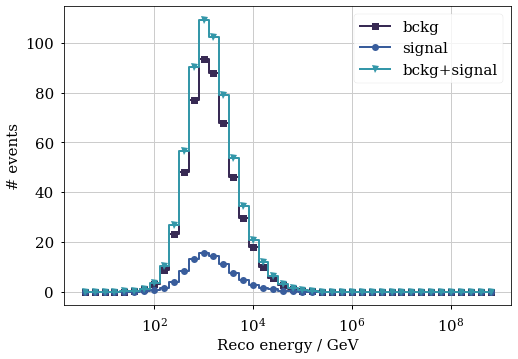

In [498]:
# we only need the (average) effective area at the location of NGC1068
# since the solid angle of this analysis is small enough
# background expectation
delta_psi = 2
aeff_factor = (
    aeff_2d["IceCube"][:, ngc_bin_index]
    * lt_kde
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
)
atmo = atmo_background(aeff_factor, spl_vals[ngc_bin_index])
print("Delta Psi bin:", np.sum(atmo))
N_bckg_expect = np.sum(atmo)


plt.figure()
plt.plot(10 ** (e_reco_mids), atmo, label="bckg", drawstyle="steps-mid", marker="s")

# calculate events per ngc pixel with newest 'science' NGC1068 flux
aeff_factor = aeff_2d["IceCube"][:, ngc_bin_index] * lt_kde * ewidth
# flux is already integrated over solid angle, because it's a point source
# phi = 5 * 10^{-11} / TeV cm² s = 5E-14 /G eV...
# gamma = 3.2
# e_norm = 1E3 (1 TeV)
# new normalization: e_norm = 100 TeV
# --> phi = 2* 1E-20
GAMMA_NGC = 3.2
PHI_PS = 5e-14
PHI_NGC = PHI_PS * (E_NORM / 1e3) ** (-GAMMA_NGC)  # -> 2E-20
astro_ev = astro_flux("powerlaw", aeff_factor, emids, E_NORM, GAMMA_NGC, PHI_NGC / PHI_0)
N_sig_expect = np.sum(astro_ev)
print("NGC 1068 expectation (newest paper):", N_sig_expect)

plt.plot(
    10 ** (e_reco_mids), astro_ev, label="signal", drawstyle="steps-mid", marker="o"
)
plt.plot(
    10 ** (e_reco_mids),
    astro_ev + atmo,
    label="bckg+signal",
    drawstyle="steps-mid",
    marker="v",
)
plt.xscale("log")
# plt.ylim(0, 70)
plt.legend(loc=0)
plt.ylabel("# events")
plt.xlabel("Reco energy / GeV")


# as comparison, calculate events per ngc pixel with 10yr PS NGC1068 flux
aeff_factor = aeff_2d["IceCube"][:, ngc_bin_index] * lt_10yr * ewidth
# phi = 3 * 10^{-11} / TeV cm² s
# gamma = 3.2
# e_norm = 1E3 (1 TeV)
# new normalization: e_norm = 100 TeV
# --> phi = 1.2 * 1E-20
PHI_NGC_ps = 3e-14 * (E_NORM / 1e3) ** (-GAMMA_NGC)  # -> 1.2E-20
astro_ev = astro_flux("powerlaw", aeff_factor, emids, E_NORM, GAMMA_NGC, PHI_NGC_ps / PHI_0)
print("astro_flux method: NGC 1068 expectation (10yr PS):", np.sum(astro_ev))


### Expected angular distribution

(0.0, 100.0)

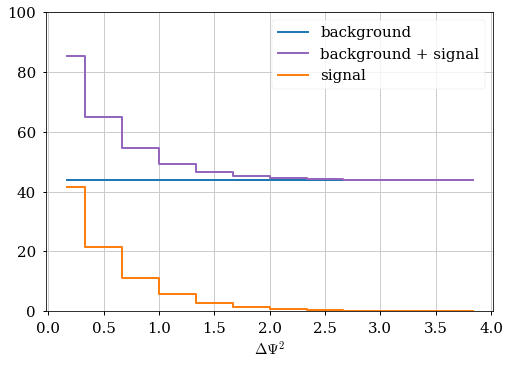

In [497]:
# generate some random data in delta psi resembling a source
# all in degree
limit = delta_psi ** 2
bins = np.arange(0, limit + 0.1, step=1/3)
bin_mids = get_mids(bins)
bin_width = bin_mids[1] - bin_mids[0]
signal_width = 0.5  # degree

# expectation
mu_b_base = np.full_like(bin_mids, N_bckg_expect / len(bin_mids))
mu_s_base = chi2.pdf(bin_mids, 2, scale=signal_width**2) * N_sig_expect * bin_width

plt.figure()
# background
plt.plot(bin_mids, mu_b_base, color="tab:blue", label="background", ds="steps-mid")
# signal
plt.plot(bin_mids, mu_s_base + mu_b_base, color="tab:purple", label="background + signal", ds="steps-mid")
plt.plot(bin_mids, mu_s_base, color="tab:orange", label="signal", ds="steps-mid")
plt.xlabel(r"$\Delta \Psi^2$")
plt.legend()
plt.ylim(0, 100)


## Experimental data cross check

In [451]:
from glob import glob
from tools import ang_dist

In [473]:
exp_data = []
for fn in glob("/data/plenum/icecube_10year_ps/events/*.csv"):
    ident = fn.split("/")[-1].split("_exp")[0]
    exp_data.extend(np.genfromtxt(fn, names=True))
exp_data = np.array(exp_data)

In [499]:
N_bckg_expect

524.9763542718177

In [501]:
angular_distances = np.rad2deg(
    ang_dist(
        ngc1068.ra.rad,
        ngc1068.dec.rad,
        np.deg2rad(exp_data["RAdeg"]),
        np.deg2rad(exp_data["Decdeg"]),
    )
)

ngc_events_distances = angular_distances[angular_distances <= delta_psi]  # degree


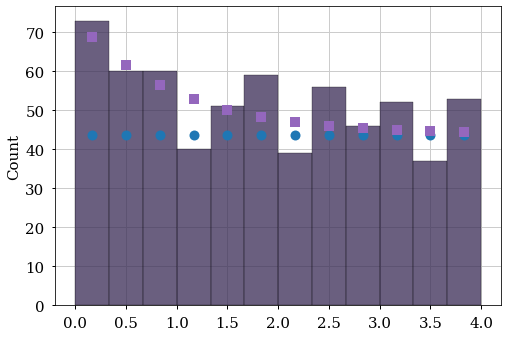

In [506]:
limit = delta_psi**2
bins = np.linspace(0, limit, limit * 3 + 1)
sns.histplot(ngc_events_distances**2, bins=bins)

bin_mids = get_mids(bins)
bin_width = bin_mids[1] - bin_mids[0]
signal_width = 0.7  # degree

# expectation
mu_b_base = np.full_like(bin_mids, N_bckg_expect / len(bin_mids))
mu_s_base = chi2.pdf(bin_mids, 2, scale=signal_width**2) * N_sig_expect * bin_width

# background
plt.plot(
    bin_mids, mu_b_base, color="tab:blue", label="background", lw=0, marker="o", ms=10
)
# signal
plt.plot(
    bin_mids,
    mu_s_base + mu_b_base,
    color="tab:purple",
    label="background + signal",
    lw=0,
    marker="s",
    ms=10,
)


## Test combined fit

we will base this on a 2D fit in Psi and reco energy

In [393]:
# Background expectation for one small bin with radius of 2deg
delta_psi = 2
aeff_factor_bckg = (
    aeff_2d["IceCube"][:, ngc_bin_index]
    * lt_kde
    * ewidth
    * (np.deg2rad(delta_psi) ** 2) * np.pi
)
atmo = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
N_bckg_expect = np.sum(atmo)


# calculate events per ngc pixel with newest 'science' NGC1068 flux
# we only need the (average) effective area at the location of NGC1068
aeff_factor_signal = aeff_2d["IceCube"][:, ngc_bin_index] * lt_kde * ewidth
# flux is already integrated over solid angle, because it's a point source
astro_ev = astro_flux("powerlaw", aeff_factor_signal, emids, E_NORM, GAMMA_NGC, PHI_NGC/PHI_0)
N_sig_expect = np.sum(astro_ev)
print(N_bckg_expect, N_sig_expect)


limit = delta_psi ** 2
bins = np.arange(0, limit + 0.1, step=0.1)
bin_mids = get_mids(bins)
bin_width = bin_mids[1] - bin_mids[0]
signal_width = 0.5  # degree

# expectation
mu_b_base_SP = np.full_like(bin_mids, N_bckg_expect / len(bin_mids))
mu_s_base_SP = chi2.pdf(bin_mids, 2, scale=signal_width**2) * N_sig_expect * bin_width




524.9763542718177 87.15826962483074


In [407]:
from scipy.stats import gaussian_kde

### Get the PSF functions from the smearing matrix

In [394]:
public_data_hist = np.genfromtxt("../resources/IC86_II_smearing.csv", skip_header=1)
# #   0                    1                    2                3                4                 5
# #  log10(E_nu/GeV)_min  log10(E_nu/GeV)_max  Dec_nu_min[deg]  Dec_nu_max[deg]  log10(E/GeV)_min  log10(E/GeV)_max
# #   6              7            8               9                 10
# #  PSF_min[deg]  PSF_max[deg]  AngErr_min[deg]  AngErr_max[deg]  Fractional_Counts


In [812]:
logE_sm_min, logE_sm_max = public_data_hist[:, 0], public_data_hist[:, 1]
logE_sm_mids = (logE_sm_min + logE_sm_max) / 2.0
dec_sm_min, dec_sm_max = public_data_hist[:, 2], public_data_hist[:, 3]
dec_sm_mids = (dec_sm_min + dec_sm_max) / 2.0
log_psf_min, log_psf_max = np.log10(public_data_hist[:, 6]), np.log10(
    public_data_hist[:, 7]
)
psf_mids = (public_data_hist[:, 6] + public_data_hist[:, 7]) / 2.0
log_psf_mids = np.log10(psf_mids)
# logEreco_sm_min, logEreco_sm_max = public_data_hist[:, 4], public_data_hist[:, 5]
# logEreco_sm_mids = (logEreco_sm_min + logEreco_sm_max) / 2.0
# log_sigma_min, log_sigma_max = np.log10(public_data_hist[:, 8]), np.log10(
#     public_data_hist[:, 9]
# )
# log_sigma_mids = (log_sigma_min + log_sigma_max) / 2.0
fractional_event_counts = public_data_hist[:, 10]
log_psi_binning = np.linspace(-2, 2, 55)
log_psi_mids = get_mids(log_psi_binning)
# log_sigma_binning = np.linspace(-0.7, 1.2, 26)



### plot one slice in psi and psi²

$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$

Text(0.5, 0, 'psi²')

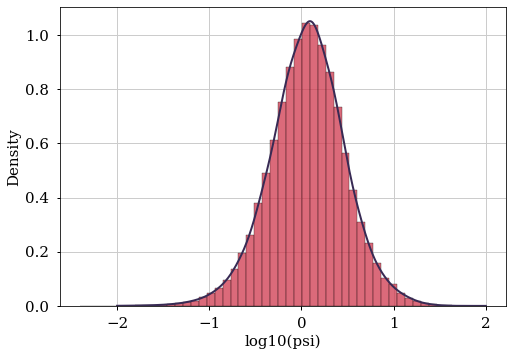

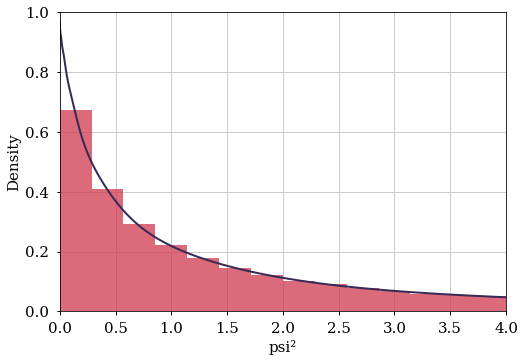

In [790]:
## KDE in log(psi)
mask = dec_sm_mids == 0
mask &= logE_sm_mids == 2.75
kde_slice = gaussian_kde(log_psf_mids[mask], weights=fractional_event_counts[mask])
log_psxx = np.linspace(-2, 2, 1000)
psxx = 10**log_psxx
# psxx = np.linspace(0.1, 180, 1000)
# log_psxx = np.log10(psxx)
sample = kde_slice.resample(100000)
ax = sns.histplot(sample.flatten(), stat="density", bins=50)
ax.plot(log_psxx, kde_slice.pdf(log_psxx))
ax.set_xlabel("log10(psi)")

plt.figure()
psY = psxx**2
psi2_sample = 10 ** (sample.flatten() * 2)
ax = sns.histplot(psi2_sample, stat="density", bins=np.concatenate([np.linspace(0, 4, 15), [np.max(psi2_sample)]]))
plt.plot(psY, kde_slice.pdf(log_psxx) / (2 * psY * np.log(10)))
plt.xlim(0, 4)
plt.ylim(0, 1)
plt.xlabel("psi²")


### Full 2D psi-energy kde

In [791]:
mask = dec_sm_mids == 0
log_emids = get_mids(np.log10(ebins))
e_psi_kdes = gaussian_kde((logE_sm_mids[mask], log_psf_mids[mask]), weights=fractional_event_counts[mask])


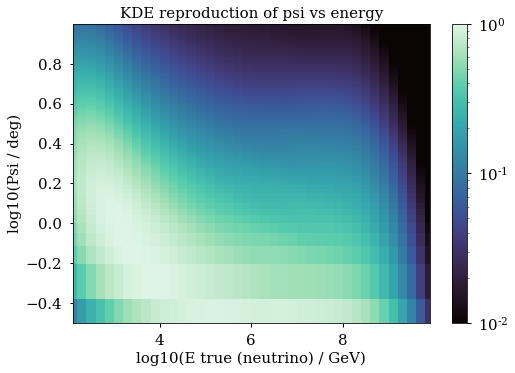

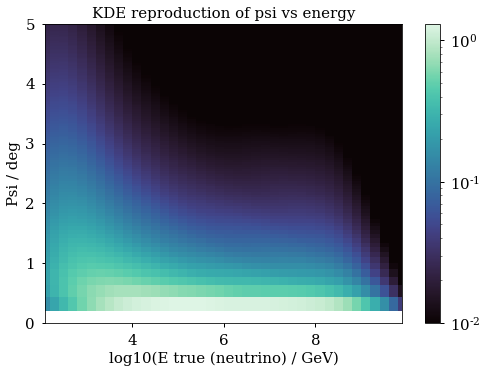

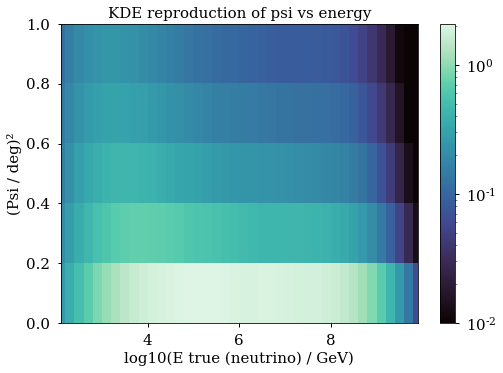

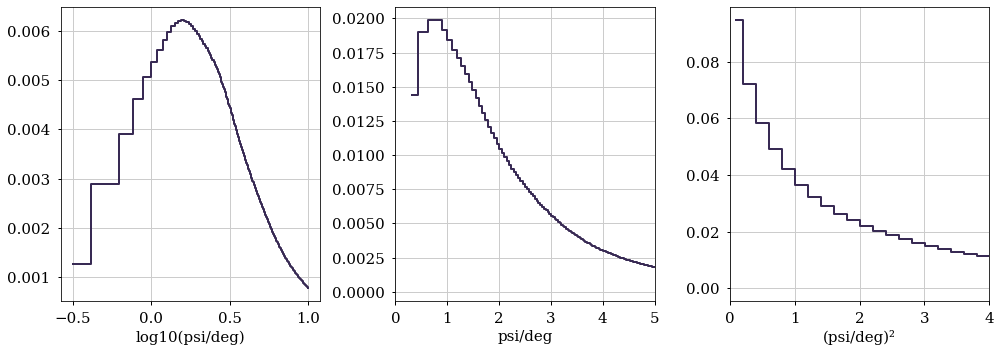

In [834]:
psi2_bins = np.linspace(0, 100, 500)
psi2_mids = get_mids(psi2_bins)
psi_mids = np.sqrt(psi2_mids)
log_psi_mids = np.log10(psi_mids)

lee, psii = np.meshgrid(log_emids, log_psi_mids)
psi_kvals = e_psi_kdes([lee.flatten(), psii.flatten()]).reshape(
    len(log_psi_mids), len(log_emids)
)


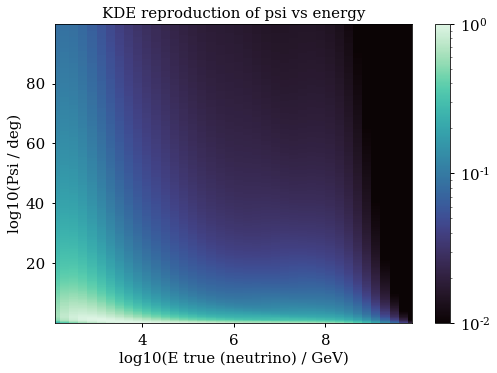

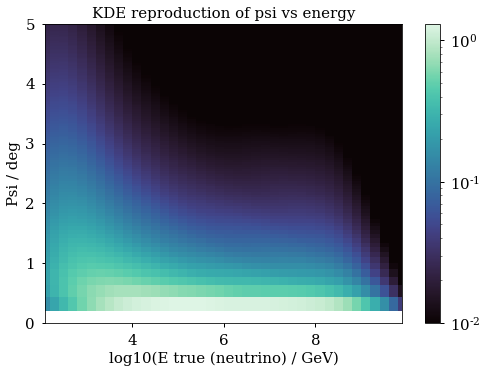

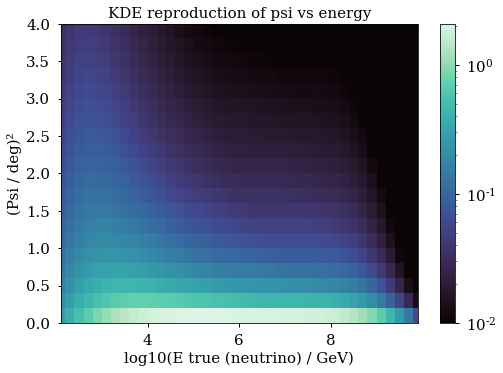

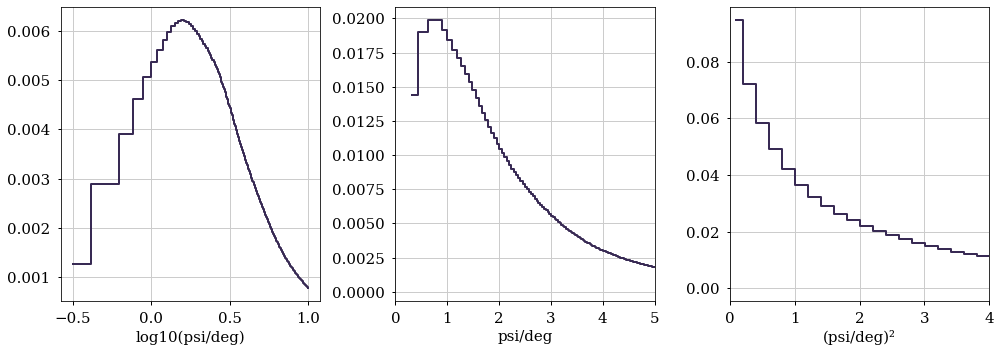

In [835]:
# log(psi) representation
plt.figure()
plt.grid(False)
plt.pcolormesh(
    lee, psii, psi_kvals / np.max(psi_kvals), norm=LogNorm(vmin=1e-2)
)
plt.colorbar()
plt.ylim(np.min(psii), np.max(psii))
plt.xlim(np.min(lee), np.max(lee))
plt.title("KDE reproduction of psi vs energy")
plt.ylabel("log10(Psi / deg)")
plt.xlabel("log10(E true (neutrino) / GeV)")

# psi representation
lee, psii = np.meshgrid(log_emids, psi_mids)
plt.figure()
plt.grid(False)
plt.pcolormesh(
    lee, psii, psi_kvals / psii / np.log(10) / np.max(psi_kvals), norm=LogNorm(vmin=1e-2)
)
plt.colorbar()
plt.ylim(0, 5)
plt.xlim(np.min(lee), np.max(lee))
plt.title("KDE reproduction of psi vs energy")
plt.ylabel("Psi / deg")
plt.xlabel("log10(E true (neutrino) / GeV)")

# psi² representation
lee, psii = np.meshgrid(log_emids, psi2_mids)
plt.figure()
plt.grid(False)
plt.pcolormesh(
    lee, psii, psi_kvals / psii / 2 / np.log(10) / np.max(psi_kvals), norm=LogNorm(vmin=1e-2)
)
plt.colorbar()
plt.ylim(0, 4)
plt.xlim(np.min(lee), np.max(lee))
plt.title("KDE reproduction of psi vs energy")
plt.ylabel("(Psi / deg)²")
plt.xlabel("log10(E true (neutrino) / GeV)")


f, axes = plt.subplots(ncols=3, figsize=(14, 5))
# log10(psi) representation
psi_int = np.sum(psi_kvals * emids ** (-GAMMA_NGC), axis=1)
psi_int /= np.sum(psi_int)
axes[0].plot(log_psi_mids, psi_int, label="PSF", ds="steps-mid")
axes[0].set_xlabel("log10(psi/deg)")


# psi respresentation
psi_int = np.sum(psi_kvals * emids ** (-GAMMA_NGC), axis=1)
psi_int /= psi_mids / np.log(10)
psi_int /= np.sum(psi_int)
axes[1].plot(psi_mids, psi_int, label="PSF", ds="steps-mid")
axes[1].set_xlabel("psi/deg")
axes[1].set_xlim(0, 5)

# psi² respresentation
psi_int = np.sum(psi_kvals * emids ** (-GAMMA_NGC), axis=1)
psi_int /= psi2_mids / np.log(10) / 2
psi_int /= np.sum(psi_int)
axes[2].plot(psi2_mids, psi_int, label="PSF", ds="steps-mid")
axes[2].set_xlabel("(psi/deg)²")
axes[2].set_xlim(0, 4)
f.tight_layout()

In [ ]:
-2 * np.sum(
    np.where(
        mu_i > 0,
        k_i * np.log(mu_i)
        - mu_i
        - 0.5 * np.log(2 * np.pi * k_i)
        + k_i
        - k_i * np.log(k_i),
        0,
    )
)


### compare pure rayleigh with actual psf (it does not look nice)

(0.0, 2.0)

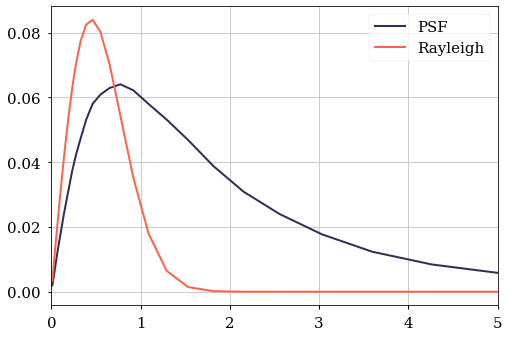

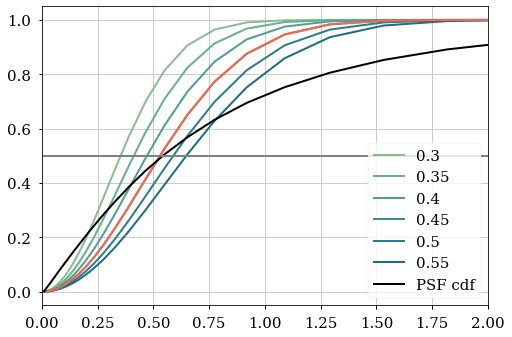

In [805]:
psi_mids = 10**log_psi_mids
rainbow = list(sns.color_palette("crest", n_colors=8))

psi_int = np.sum(psi_kvals * emids ** (-GAMMA_NGC), axis=1)
psi_int /= psi_mids / np.log(10)
psi_int /= np.sum(psi_int)


plt.plot(psi_mids,  psi_int, label="PSF")
ray = rayleigh.pdf(psi_mids, scale=0.45)
plt.plot(psi_mids, ray / np.sum(ray), label="Rayleigh", color="tomato")
plt.xlim(0, 5)

plt.legend()


plt.figure()
for ii, sc in enumerate(np.round(np.arange(0.3, 0.6, step=0.05), decimals=2)):
    plt.plot(psi_mids, rayleigh.cdf(psi_mids, scale=sc), label=sc, color=rainbow[ii])
plt.plot(psi_mids, rayleigh.cdf(psi_mids, scale=0.45), color="tomato")
plt.plot(psi_mids,  np.cumsum(psi_int), label="PSF cdf", color="k")
plt.axhline(0.5, color="gray")
plt.legend()
plt.xlim(0, 2)



## Test energy fitting

In [334]:
import warnings
from copy import deepcopy

warnings.filterwarnings("ignore")


In [348]:
def energy_composite_func(x, mu_b_base, mu_s_base, k_i, emids, PHI_PS):
    mu_b = atmo_background(mu_b_base, spl_vals[ngc_bin_index]) * x[0]
    mu_s = energy_smearing(normed_kvals, mu_s_base * x[1] * (emids / E_NORM) ** (-x[2]) * PHI_NGC)
    mu_i = mu_b + mu_s
    return -2 * np.sum(
        np.where(
            mu_i > 0,
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


def energy_null_func(x, mu_b_base, k_i):
    mu_i = atmo_background(mu_b_base, spl_vals[ngc_bin_index]) * x[0]
    return -2 * np.sum(
        np.where(
            mu_i > 0,
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


In [349]:
# background 'observation'
delta_psi = 2
aeff_factor_bckg = (
    aeff_2d["IceCube"][:, ngc_bin_index]
    * lt_kde
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
)
k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])

# signal 'observation'
aeff_factor_signal = aeff_2d["IceCube"][:, ngc_bin_index] * lt_kde * ewidth
k_s = astro_flux("powerlaw", aeff_factor_signal, emids, E_NORM, GAMMA_NGC, PHI_NGC / PHI_0)
k_i = k_s + k_b

print("Expectations:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))
# expectation
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

# evaluate with poisson statistics
# composite model
out_comp = fmin_l_bfgs_b(
    energy_composite_func,
    x0=(1.2, 1.2, 2.),
    approx_grad=True,
    args=(mu_b_base, mu_s_base, k_i, emids, PHI_NGC),
)
# background model
out_bckg = fmin_l_bfgs_b(
    energy_null_func,
    x0=(1.2,),
    approx_grad=True,
    args=(mu_b_base, k_i),
)
print(out_comp)
print(out_bckg)
pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)


mu_b_null_result = atmo_background(mu_b_base, spl_vals[ngc_bin_index]) * out_bckg[0][0]
mu_b_result = atmo_background(mu_b_base, spl_vals[ngc_bin_index]) * out_comp[0][0]
mu_s_result = energy_smearing(normed_kvals, mu_s_base * out_comp[0][1] * (emids / E_NORM) ** (-out_comp[0][2]) * PHI_NGC)
print("Signal Result:", np.sum(mu_s_result))
print("Background Result:", np.sum(mu_b_result))
print("Background-only Result:", np.sum(mu_b_null_result))

Expectations:
Background: 524.7631663195214
Signal: 87.15826962483074
(array([0.99996349, 1.00018761, 3.19996991]), -122.70723679503273, {'grad': array([-0.02440714, -0.00407994, -0.01798952]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 176, 'nit': 31, 'warnflag': 0})
(array([1.16609067]), -122.6830605398182, {'grad': array([2.84217096e-06]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 14, 'nit': 4, 'warnflag': 0})
P-VALUE: 0.8764372800087148 , SIGNIFICANCE: 0.15548715450006625
Signal Result: 87.1631945084113
Background Result: 524.7440087369678
Background-only Result: 611.9214343964862


In [362]:
from astro_flux import logE_reco_bins
logE_reco_mids = get_mids(logE_reco_bins)

Text(0.5, 0, 'Energy/GeV')

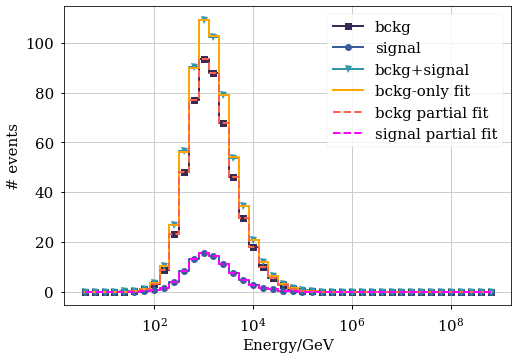

In [368]:
plt.plot(10**logE_reco_mids, k_b, label="bckg", drawstyle="steps-mid", marker="s")
plt.plot(10**logE_reco_mids, k_s, label="signal", drawstyle="steps-mid", marker="o")
plt.plot(
    10**logE_reco_mids,
    k_s + k_b,
    label="bckg+signal",
    drawstyle="steps-mid",
    marker="v",
)
plt.plot(
    10**logE_reco_mids,
    mu_b_null_result,
    label="bckg-only fit",
    drawstyle="steps-mid",
    color="orange",
)
plt.plot(
    10**logE_reco_mids,
    mu_b_result,
    label="bckg partial fit",
    drawstyle="steps-mid",
    color="tomato",
    ls="--",
)
plt.plot(
    10**logE_reco_mids,
    mu_s_result,
    label="signal partial fit",
    drawstyle="steps-mid",
    color="fuchsia",
    ls="--",
)
plt.xscale("log")
plt.legend(loc=0)
plt.ylabel("# events")
plt.xlabel("Energy/GeV")


## Test $\Delta \Psi²$ fitting

### normalization-only fit

In [369]:
def norm_composite_func(x, mu_b_base, mu_s_base, k_i):
    mu_b = mu_b_base * x[0]
    mu_s = mu_s_base * x[1]
    mu_i = mu_b + mu_s
    return -2 * np.sum(
        np.where(
            mu_i > 0,
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


def norm_null_func(x, mu_b_base, k_i):
    mu_i = mu_b_base * x[0]
    return -2 * np.sum(
        np.where(
            mu_i > 0,
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


In [370]:
from scipy.stats import rayleigh
# angular distance is rayleigh distributed

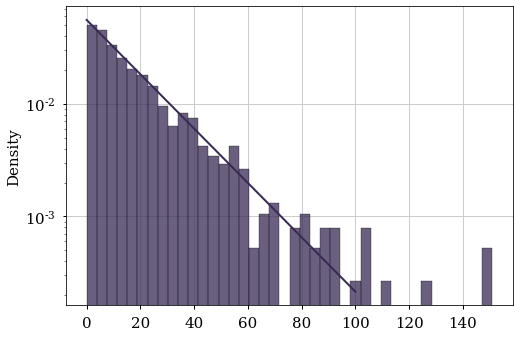

In [371]:
# visualize the angular distance distribution
# square of angular distance is chi² distributed
data = rayleigh.rvs(scale=3, size=1000) ** 2
ax = sns.histplot(data, stat="density")
x = np.linspace(0, 100)
# scale transforms to scale² in chi²
plt.plot(x, chi2.pdf(x, 2, scale=3 ** 2))
ax.set_yscale("log")


### generate some random data in delta psi resembling a source


In [ ]:
# all in degree
np.random.seed(1338)
bins = np.arange(0, delta_psi**2 + 0.1, step=0.2)
bin_mids = get_mids(bins)
bin_width = bin_mids[1] - bin_mids[0]
N_sig = int(np.round(N_sig_expect))
N_bckg = int(np.round(N_bckg_expect))
signal_width = 0.5  # degree

bckg = np.random.uniform(0, limit, size=N_bckg)  # degree
# transform from 2D gauss in (RA, dec) -> 1D Rayleigh in delta Psi -> Chi² in (delta Psi)²
signal = chi2.rvs(2, scale=signal_width**2, size=N_sig)



plt.figure()
k_s, _ = np.histogram(signal, bins=bins)
k_b, _ = np.histogram(bckg, bins=bins)
k_i = k_s + k_b

# expectation
mu_b_base = np.full_like(k_b, N_bckg / len(bin_mids))
mu_s_base = chi2.pdf(bin_mids, 2, scale=signal_width**2) * N_sig * bin_width

# plt.figure()
# ax = sns.histplot(signal, bins=bins)
# ax.plot(bin_mids, mu_s_base)
# ax.set_title("Signal only")

# evaluate with poisson statistics
# composite model
out_comp = fmin_l_bfgs_b(
    norm_composite_func,
    x0=(1, 1),
    approx_grad=True,
    args=(mu_b_base, mu_s_base, k_i),
)
# background model
out_bckg = fmin_l_bfgs_b(
    norm_null_func,
    x0=(1,),
    approx_grad=True,
    args=(mu_b_base, k_i),
)
print(out_comp)
print(out_bckg)
pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)

# plotting
plt.figure()
ax = sns.histplot(
    [signal, bckg], multiple="stack", bins=bins, palette=["tab:purple", "tab:blue"]
)
# expectation + fit
# background
ax.plot(bin_mids, mu_b_base, color="tab:blue", label="background")
ax.plot(bin_mids, mu_b_base * out_bckg[0][0], color="blue", label="background-only fit")
# signal
ax.plot(bin_mids, mu_s_base + mu_b_base, color="tab:purple", label="signal")
ax.plot(
    bin_mids,
    mu_b_base * out_comp[0][0] + mu_s_base * out_comp[0][1],
    color="purple",
    label="signal+bckg fit",
)
ax.set_xlabel(r"$\Delta \Psi^2 / {\rm deg}^2$")
ax.legend()



### generate some Asimov data in delta psi resembling a source


(array([1., 1.]), 68.93542620467468, {'grad': array([1.70530258e-05, 1.70530258e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 0, 'warnflag': 2})
(array([1.16299965]), 99.19573139776418, {'grad': array([-5.68434192e-06]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 12, 'nit': 4, 'warnflag': 0})
P-VALUE: 3.777787111364568e-08 , SIGNIFICANCE: 5.500936756241663


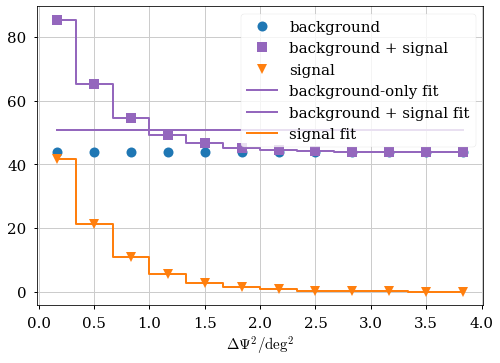

In [385]:
# all in degree
limit = delta_psi**2
bins = np.arange(0, limit + 0.1, step=1 / 3)
bin_mids = get_mids(bins)
bin_width = bin_mids[1] - bin_mids[0]

signal_width = 0.5  # degree

# expectation
mu_b_base = np.full_like(bin_mids, N_bckg_expect / len(bin_mids))
mu_s_base = chi2.pdf(bin_mids, 2, scale=signal_width**2) * N_sig_expect * bin_width

k_s = deepcopy(mu_s_base)
k_b = deepcopy(mu_b_base)
k_i = k_s + k_b

# evaluate with poisson statistics
# composite model
out_comp = fmin_l_bfgs_b(
    norm_composite_func,
    x0=(1, 1),
    approx_grad=True,
    args=(mu_b_base, mu_s_base, k_i),
)
# background model
out_bckg = fmin_l_bfgs_b(
    norm_null_func,
    x0=(1,),
    approx_grad=True,
    args=(mu_b_base, k_i),
)
print(out_comp)
print(out_bckg)
pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)

# plotting
plt.figure()
# expectation
plt.plot(
    bin_mids, mu_b_base, color="tab:blue", label="background", marker="o", lw=0, ms=10
)
plt.plot(
    bin_mids,
    mu_s_base + mu_b_base,
    color="tab:purple",
    label="background + signal",
    marker="s",
    lw=0,
    ms=10,
)
plt.plot(
    bin_mids, mu_s_base, color="tab:orange", label="signal", marker="v", lw=0, ms=10
)

# fit
plt.plot(
    bin_mids,
    mu_b_base * out_bckg[0][0],
    color="tab:purple",
    label="background-only fit",
    ds="steps-mid",
)
plt.plot(
    bin_mids,
    mu_s_base * out_comp[0][1] + mu_b_base * out_comp[0][0],
    color="tab:purple",
    label="background + signal fit",
    ds="steps-mid",
)
plt.plot(
    bin_mids,
    mu_s_base * out_comp[0][1],
    color="tab:orange",
    label="signal fit",
    ds="steps-mid",
)

plt.xlabel(r"$\Delta \Psi^2 / {\rm deg}^2$")
plt.legend()


# Define likelihood and test statistic

In [19]:
def spectral_ts_func(x, aeff_factor, emids, enorm, k_i, shape, verbose=False, **kwargs):
    """First parameter is always conv scaling, rest is defined in astro_flux()"""
    # free parameters
    _conv_scaling = x[0]
    background_spl = kwargs.pop("background_spl", spl_vals)
    # astro events with single powerlaw
    # this is already smeared in energy
    astro_ev = astro_flux(shape, aeff_factor, emids, enorm, *x[1:])
    if verbose:
        print(x)
        print(*x[1:])
        print(np.sum(astro_ev))
    # atm events based on MCEQ with scaling factor
    atm_ev = atmo_background(aeff_factor, background_spl * _conv_scaling)
    # this defines the LLH function with free parameters
    all_mu_i = astro_ev + atm_ev
    return -2 * np.sum(
        np.where(
            all_mu_i > 0,
            k_i * np.log(all_mu_i)
            - all_mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


In [20]:
def local_ts_func(x, fixed_params, free_positions, fixed_params_positions, *args):
    r"""Reduce full likelihood function with fixed parameters, i.e. reduce to
    a 'local' likelihood function. Free and fixed parameters are combined in one
    array to be piped through to 'spectral_ts_func'.
    -----------------------------------------------------------------------

    x: free parameters, piped through to 'spectral_ts_func'
    fixed_params: value of fixed parameters
    free_positions: array indices of free parameters
    fixed_params_positions: array indices of fixed parameters
    *args: piped through to 'spectral_ts_func'

    returns spectral_ts_func(free_and_fixed_parameters, *args)
    """
    all_x = np.zeros(len(x) + len(fixed_params))
    for i, pos in enumerate(fixed_params_positions):
        all_x[pos] = fixed_params[i]
    for i, pos in enumerate(free_positions):
        all_x[pos] = x[i]
    return spectral_ts_func(all_x, *args)


In [21]:
def asimov_data(aeff_factor, shape_key, verbose=False, **kwargs):
    shp_params = kwargs.pop("shp_params", np.copy(shape_params[shape_key]["baseline"]))
    background_spl = kwargs.pop("background_spl", spl_vals)
    # calculate asimov 'data' = expectation of perfect experiment
    astro_ev = astro_flux(shape_key, aeff_factor, emids, E_NORM, *shp_params[1:])
    if verbose:
        print("baseline astro ev", np.sum(astro_ev))
    atm_ev = atmo_background(aeff_factor, background_spl * shp_params[0])
    # asimov = expectation of perfect experiment
    return astro_ev + atm_ev


## Loop through all shapes and make a spectral fit

In [22]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = True
fit_results = {}
for shape in shape_params:
    print(shape)
    fit_results[shape] = {}
    for li, ident in enumerate(idents):
        if verbose:
            print(ident)
        aeff_factor = (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        )
        if "Plenum" in ident:
            aeff_factor += (
                aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
                * LIVETIME
            )
        # asimov = expectation of perfect experiment
        k_i = asimov_data(aeff_factor, shape, verbose=False)

        # global min
        out = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params[shape]["guess"],
            bounds=shape_params[shape]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, shape),
        )
        print("shape fit:", out[0])
        fit_results[shape][ident] = out
        if out[2]["warnflag"] != 0:
            print("WARNING!!")

        # check that the TS at the fit minimum is close to the TS of the baseline params
        baseline_ts = spectral_ts_func(
            shape_params[shape]["baseline"], aeff_factor, emids, E_NORM, k_i, shape
        )
        baseline_ts_check = np.isclose(out[1], baseline_ts, rtol=1e-3)
        print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
        print("fit: ", out[1], ", reference:", baseline_ts)
        # best fit powerlaw as null hypothesis
        out_pl = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params["powerlaw"]["guess"],
            bounds=shape_params["powerlaw"]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, "powerlaw"),
        )
        ## be aware: this doesn't tell you whether or not the fit worked
        ## a 2D scan can confirm (see below)
        print("pl fit:", out_pl[0])
        pval = chi2.sf(out_pl[1] - out[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)
        if False:  # verbose:
            print("asimov baseline param: ", shape_params[shape]["baseline"])
            print("bf param:", fit_results[shape][ident][0])
            print("guess param: ", shape_params[shape]["guess"])
            print(
                "diff (truth vs fit):",
                shape_params[shape]["baseline"] / fit_results[shape][ident][0] - 1,
            )
            print("* *" * 30)
    print("- -" * 30)


powerlaw
IceCube
shape fit: [0.99998317 2.28085161 1.44431307]
TS asimov check: OK
fit:  818.7697912716562 , reference: 818.7695635662822
pl fit: [0.99998317 2.28085161 1.44431307]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
Plenum-1
shape fit: [0.99999164 2.28043265 1.44218269]
TS asimov check: OK
fit:  5174.809187682642 , reference: 5174.808872215566
pl fit: [0.99999164 2.28043265 1.44218269]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
Plenum-2
shape fit: [0.99999975 2.2800138  1.44002146]
TS asimov check: OK
fit:  6323.516119888611 , reference: 6323.516119575412
pl fit: [0.99999975 2.2800138  1.44002146]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
powerlaw with cutoff
IceCube
shape fit: [1.00000027 2.00000133 1.50052546 5.99961478]
TS asimov check: OK
fit:  -1147.9176927013764 , reference: -1147.9176945467261
pl fit: [0.99828901 2.41845803 1.08946147]
P-VALUE: 0.12926413859452204 , SIGNIFICANCE: 1.5170100819432395
Plenum-1
sh

powerlaw


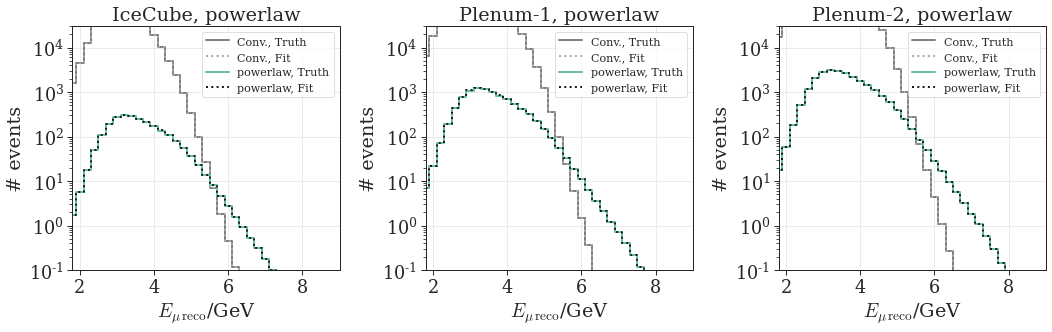

powerlaw with cutoff


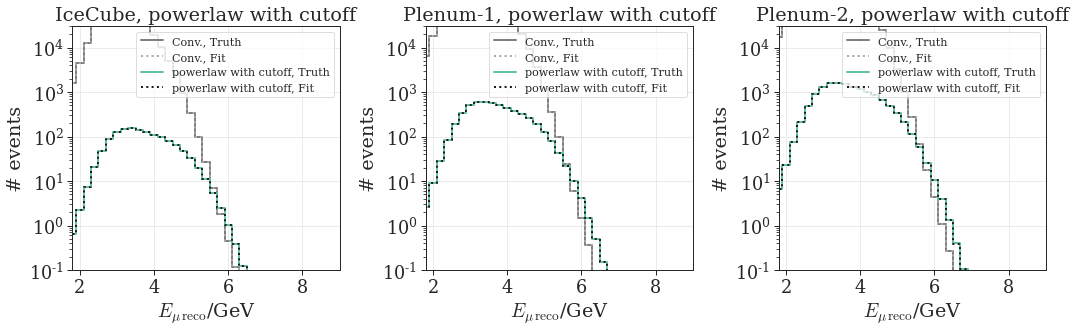

log-parabola


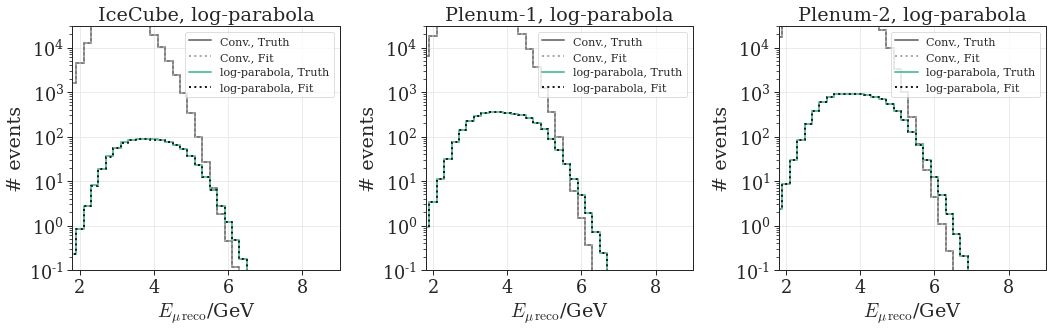

double powerlaw


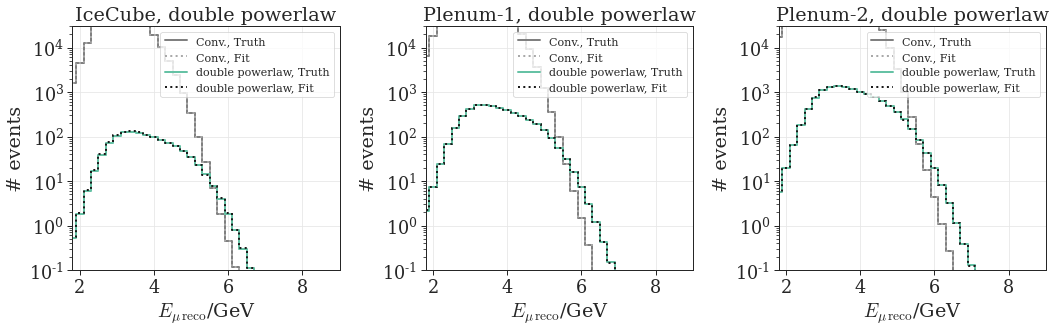

powerlaw with sigmoid


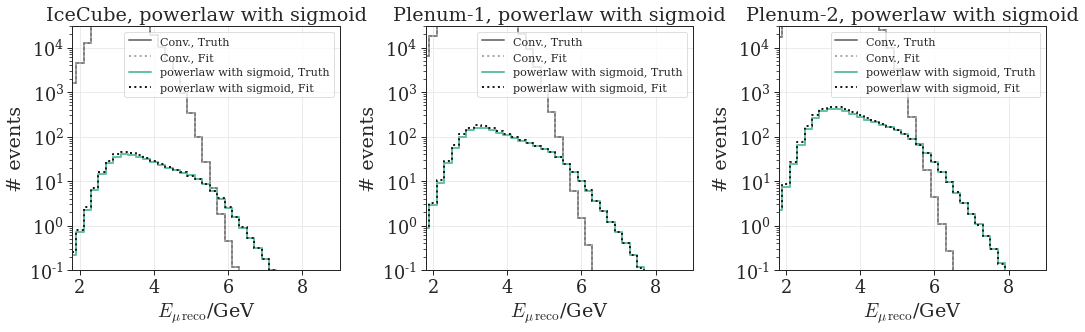

powerlaw with dip


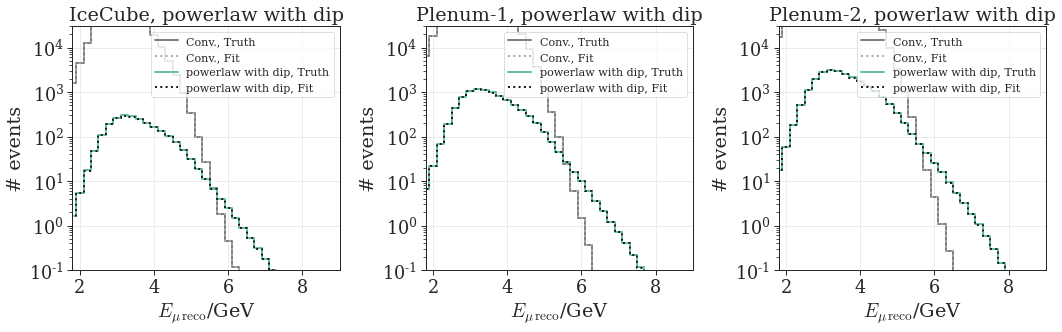

powerlaw with bump


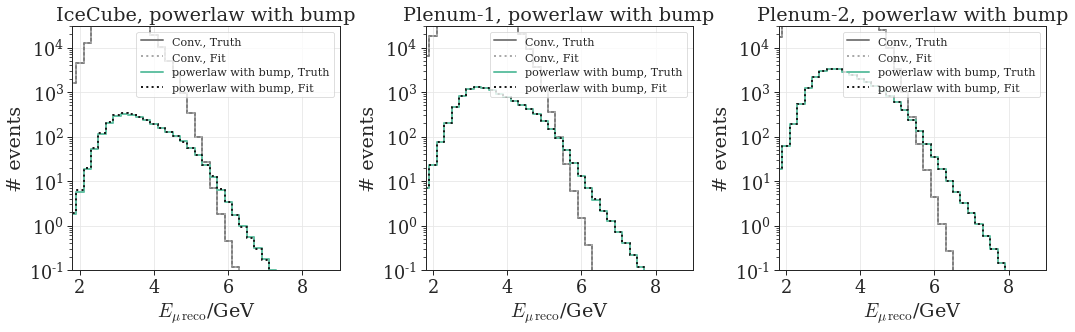

In [23]:
### make corresponding best-fit and truth plots
for shape in shape_params:
    print(shape)
    f, axes = plt.subplots(ncols=3, figsize=(15, 5))
    for li, ident in enumerate(idents):
        ax = axes[li]
        aeff_factor = (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        )
        events = [
            np.sum(
                atmo_background(
                    aeff_factor, spl_vals * shape_params[shape]["baseline"][0]
                ),
                axis=0,
            ),
            np.sum(
                atmo_background(
                    aeff_factor, spl_vals * fit_results[shape][ident][0][0]
                ),
                axis=0,
            ),
            np.sum(
                astro_flux(
                    shape,
                    aeff_factor,
                    emids,
                    E_NORM,
                    *shape_params[shape]["baseline"][1:]
                ),
                axis=0,
            ),
            np.sum(
                astro_flux(
                    shape, aeff_factor, emids, E_NORM, *fit_results[shape][ident][0][1:]
                ),
                axis=0,
            ),
        ]
        plot_labels = ["Conv., Truth", "Conv., Fit", shape + ", Truth", shape + ", Fit"]
        ls = ["-", ":", "-", ":"]
        color = ["gray", "darkgray", None, "k"]
        f, ax = plot_spectrum(
            e_reco_mids,
            events,
            plot_labels,
            title=ident + ", " + shape,
            f=f,
            ax=ax,
            ls=ls,
            color=color,
        )
        ax.legend(fontsize="xx-small", loc=1)
        f.tight_layout()
    plt.show()


## 1D scan powerlaw
Calculate expected parameter uncertainties

In [37]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 100
gamma_astro_scaling = np.linspace(1.9, 2.7, num=num + 1)
astro_scaling = np.linspace(0.4, 2.6, num=num)


In [40]:
np.zeros_like(gamma_astro_scaling) * np.nan


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [41]:
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL_gamma_scan = {"ts": {}, "conv": {}, "phi_astro": {}}
local_SPL_phi_scan = {"ts": {}, "conv": {}, "gamma": {}}
shape = "powerlaw"
for ident in idents:
    print(ident)
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    if "Plenum" in ident:
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
            * LIVETIME
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape),
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("asimov param: ", shape_params[shape]["baseline"])
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]

    local_SPL_gamma_scan["ts"][ident] = np.zeros_like(gamma_astro_scaling) * np.nan
    local_SPL_gamma_scan["conv"][ident] = np.zeros_like(gamma_astro_scaling) * np.nan
    local_SPL_gamma_scan["phi_astro"][ident] = (
        np.zeros_like(gamma_astro_scaling) * np.nan
    )
    print("starting local fits...")
    for j, gas in enumerate(gamma_astro_scaling):
        # local min with fixed gamma_astro_scaling
        local_out = fmin_l_bfgs_b(
            local_ts_func,
            x0=[1.0, 1.0],
            approx_grad=True,
            args=([gas], (0, 2), (1,), aeff_factor, emids, E_NORM, k_i, shape),
            maxls=35,
        )
        if local_out[2]["warnflag"] == 0:
            local_SPL_gamma_scan["conv"][ident][j] = local_out[0][0]
            local_SPL_gamma_scan["phi_astro"][ident][j] = local_out[0][1]
            local_SPL_gamma_scan["ts"][ident][j] = local_out[1]

    local_SPL_phi_scan["ts"][ident] = np.zeros_like(astro_scaling) * np.nan
    local_SPL_phi_scan["conv"][ident] = np.zeros_like(astro_scaling) * np.nan
    local_SPL_phi_scan["gamma"][ident] = np.zeros_like(astro_scaling) * np.nan
    print("starting local fits...")
    for j, aas in enumerate(astro_scaling):
        # local min with fixed phi_astro
        local_out = fmin_l_bfgs_b(
            local_ts_func,
            x0=[1.0, 2.2],
            approx_grad=True,
            args=([aas], (0, 1), (2,), aeff_factor, emids, E_NORM, k_i, shape),
            maxls=35,
        )
        if local_out[2]["warnflag"] == 0:
            local_SPL_phi_scan["conv"][ident][j] = local_out[0][0]
            local_SPL_phi_scan["gamma"][ident][j] = local_out[0][1]
            local_SPL_phi_scan["ts"][ident][j] = local_out[1]
    print("done")


IceCube
baseline astro ev 2338.1754666194474
asimov param:  [1.   2.28 1.44]
bf param: [1.00001413 2.27927639 1.43638237]
starting local fits...
starting local fits...
done
Plenum-1
baseline astro ev 11687.013823726706
asimov param:  [1.   2.28 1.44]
bf param: [1.00001559 2.27916861 1.43608642]
starting local fits...
starting local fits...
done
Plenum-2
baseline astro ev 26830.777528561004
asimov param:  [1.   2.28 1.44]
bf param: [1.00000013 2.27997296 1.4400414 ]
starting local fits...
starting local fits...
done


Text(0, 0.5, '-2$\\Delta$LLH')

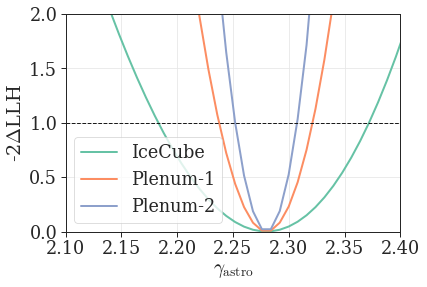

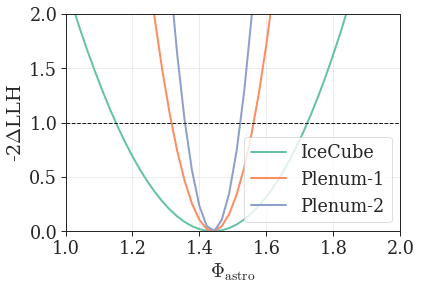

In [47]:
plt.figure()
for ident in idents:
    # mask invalid values where the fit failed
    mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        gamma_astro_scaling[mask],
        local_SPL_gamma_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 2)
plt.xlim(2.1, 2.4)
plt.legend(loc=3)
plt.xlabel(r"$\gamma_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")

plt.figure()
for ident in idents:
    # mask invalid values where the fit failed
    mask = local_SPL_phi_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        astro_scaling[mask],
        local_SPL_phi_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 2)
plt.xlim(1, 2)
plt.legend(loc=4)
plt.xlabel(r"$\Phi_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")


## 2D scan powerlaw
Show that we can roughly reproduce the diffuse results from ICRC2019

In [48]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1.9, 2.7, num=num + 1)
astro_scaling = np.linspace(0.4, 2.6, num=num)


In [49]:
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL = {"ts": {}, "conv": {}}

shape = "powerlaw"
for ident in idents:
    print(ident)
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    if "Plenum" in ident:
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
            * LIVETIME
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape),
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("asimov param: ", shape_params[shape]["baseline"])
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]

    local_SPL["ts"][ident] = np.zeros((num, num + 1))
    local_SPL["conv"][ident] = np.zeros((num, num + 1))
    print("starting local fits...")
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_out = fmin_l_bfgs_b(
                local_ts_func,
                x0=[1.1],
                approx_grad=True,
                args=([gas, asc], (0,), (1, 2), aeff_factor, emids, E_NORM, k_i, shape),
            )
            (local_SPL["conv"][ident][i][j],) = local_out[0]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


IceCube
baseline astro ev 2338.1754666194474
asimov param:  [1.   2.28 1.44]
bf param: [1.00001413 2.27927639 1.43638237]
starting local fits...
done
Plenum-1
baseline astro ev 11687.013823726706
asimov param:  [1.   2.28 1.44]
bf param: [1.00001559 2.27916861 1.43608642]
starting local fits...
done
Plenum-2
baseline astro ev 26830.777528561004
asimov param:  [1.   2.28 1.44]
bf param: [1.00000013 2.27997296 1.4400414 ]
starting local fits...
done


## contour comparison

In [63]:
# comparison data of official 9.5yr fit by Jöran Stettner (IceCube ICRC2019)
diffuse_10yr_ref = np.genfromtxt("../resources/10yr_diffuse_ICRC2019_tmp.txt")


In [51]:
### only 95% contours
contour_formats = {
    "IceCube": {"colors": [poles["IceCube"]["color"]], "linestyles": "--"},
    "Plenum-1": {
        "colors": [poles["Plenum-1"]["color"]],
        "linestyles": poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [poles["Plenum-2"]["color"]],
        "linestyles": poles["Plenum-2"]["ls"],
    },
}


In [52]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1.9, 2.7, num=num + 1)
astro_scaling = np.linspace(0.4, 2.6, num=num)


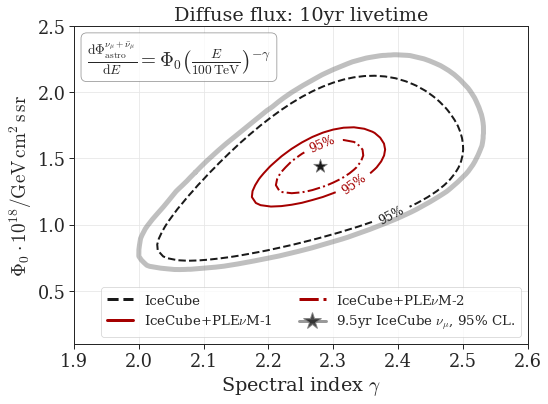

In [64]:
f, ax = plt.subplots(figsize=(8, 6))
## correctly sort extracted contour from joeran's latest diffuse fit
ref_color = "gray"
ax.plot(
    diffuse_10yr_ref[:, 0],
    diffuse_10yr_ref[:, 1],
    color=ref_color,
    ls="-",
    lw=5,
    alpha=0.5,
)

# draw contour levels
cvals = [0.05]
lbs = ["95%"]
levels = chi2.isf(cvals, 2)
for ident in idents:
    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        lw=3,
        **contour_formats[ident],
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=12)
# best fit
ax.scatter(
    bf_SPL["gamma"][ident],
    bf_SPL["phi_astro"][ident],
    marker="*",
    s=200,
    color="k",
    edgecolor=ref_color,
)
lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IceCube",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IceCube+PLE$\nu$M-1",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IceCube+PLE$\nu$M-2",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="k",
        mec=ref_color,
        label=r"9.5yr IceCube $\nu_\mu$, 95% CL.",
    ),
]
ax.set_ylim(0.1, 2.5)
ax.set_xlim(1.9, 2.6)
ax.legend(handles=lines, loc=4, ncol=2, fontsize="x-small")
ax.set_ylabel(r"$\Phi_0 \cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
ax.set_xlabel(r"Spectral index $\gamma$")
flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 100\,TeV} \right)^{-\gamma}$"
ax.text(
    1.92,
    2.2,
    flux_str,
    fontsize="medium",
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
)
ax.set_title("Diffuse flux: 10yr livetime")
f.tight_layout()
f.savefig(f"../plots/2D_scan_diffuse_spl_comparison.pdf")


### full scan comparison

IceCube
Plenum-1
Plenum-2


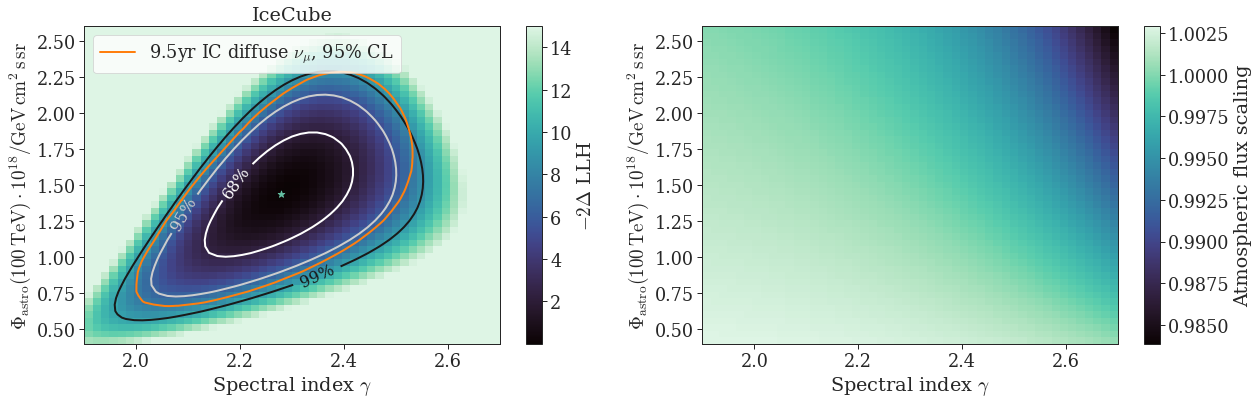

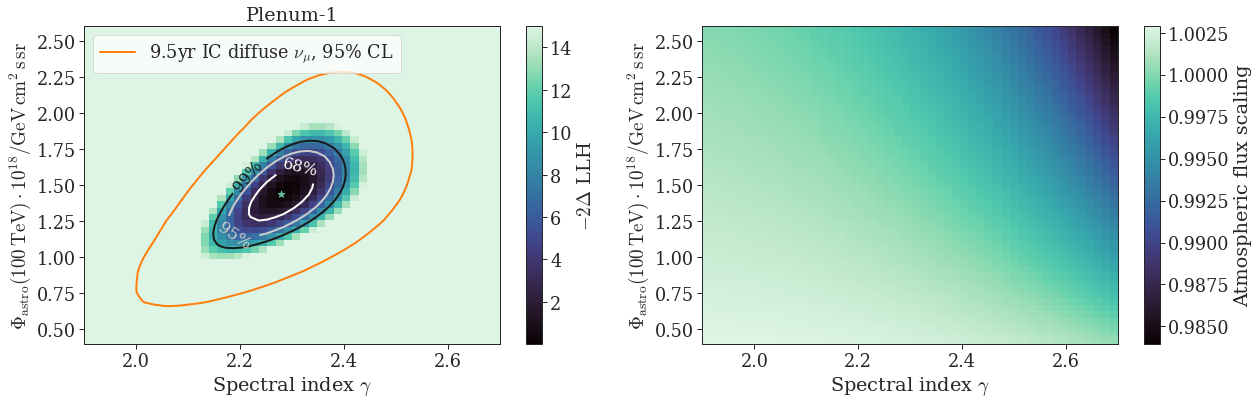

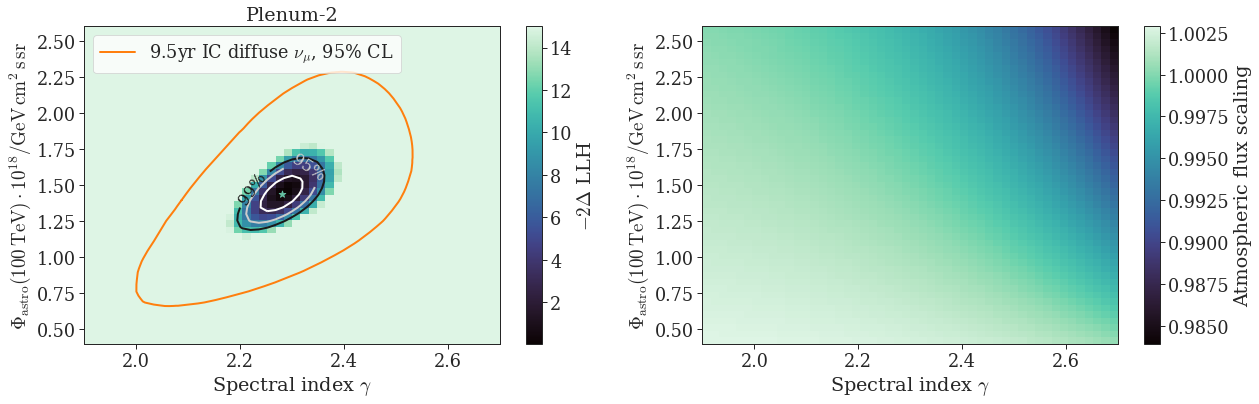

In [65]:
ref_color = "tab:orange"
for ident in idents:
    print(ident)
    ### plotting ###
    f, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "k"],
    )
    ax.scatter(bf_SPL["gamma"][ident], bf_SPL["phi_astro"][ident], marker="*", s=50)
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.plot(
        diffuse_10yr_ref[:, 0],
        diffuse_10yr_ref[:, 1],
        color=ref_color,
        label=r"9.5yr IC diffuse $\nu_\mu$, 95% CL",
    )
    ax.legend(loc=2)
    ax.set_ylabel(
        r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$"
    )
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)

    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["conv"][ident],
    )
    ax.set_ylabel(
        r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$"
    )
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")

    f.tight_layout()
    f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")


## 1D scan with cutoff

IceCube
starting local fits...
alternative: powerlaw fit (conv, gamma, phi_astro) [0.99828938 2.41851549 1.08918381]
params at min verified with scan: (conv, gamma, phi_astro) 0.9984249275871718 2.14 1.841379310344828
min TS: -1145.6163730546677 verified with scan: -1145.605630739401
Raw TS vals of powerlaw vs cutoff: -1145.6163730546677 -1147.9176927013764
P-VALUE: 0.12926413376884227 , SIGNIFICANCE: 1.5170101010568906
Plenum-1
starting local fits...
alternative: powerlaw fit (conv, gamma, phi_astro) [0.99830462 2.41440632 1.10017838]
params at min verified with scan: (conv, gamma, phi_astro) 0.9984351558194038 2.14 1.841379310344828
min TS: 66.82166784276978 verified with scan: 66.85416971072482
Raw TS vals of powerlaw vs cutoff: 66.82166784276978 57.90883843507163
P-VALUE: 0.002831741860268942 , SIGNIFICANCE: 2.9854362173220594
Plenum-2
starting local fits...
alternative: powerlaw fit (conv, gamma, phi_astro) [0.99830201 2.41614598 1.09368469]
params at min verified with scan: (conv

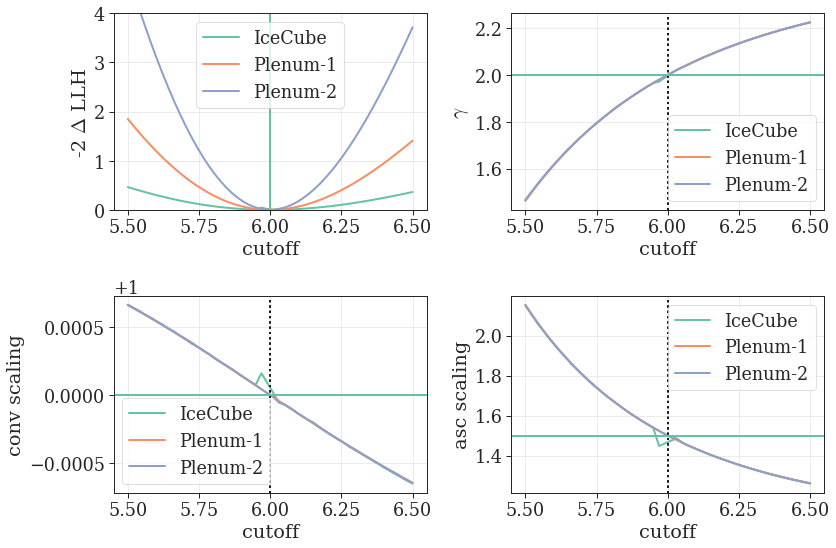

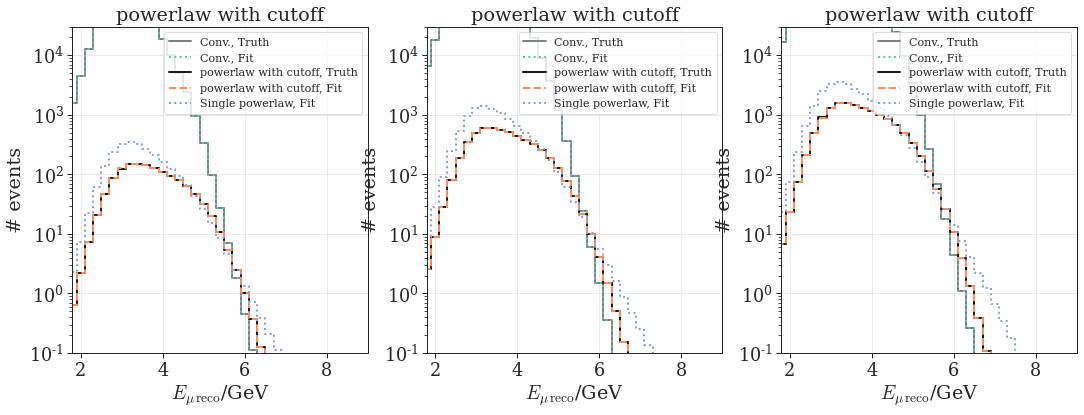

In [66]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = False
num = 50
cutoff = np.linspace(5.5, 6.5, num=num)

num1 = 30
gamma_astro_scaling = np.linspace(1.9, 2.7, num=num1 + 1)
astro_scaling = np.linspace(0.4, 2.6, num=num1)

ts_mins_pl = {}
gamma_mins_pl = {}
phi_astro_mins_pl = {}

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
f1, axes1 = plt.subplots(ncols=3, figsize=(18, 6))
for li, ident in enumerate(idents):
    print(ident)
    shape = "powerlaw with cutoff"
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape),
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    if verbose:
        print("asimov param: ", *shape_params[shape]["baseline"][1:])
        print("guess param: ", *shape_params[shape]["guess"])
        print("bf param:", out[0])
        print("TS:", out[1])
        print("* *" * 20)

    local_ts_min = np.zeros(num)
    local_param_min = {
        "gamma": np.zeros(num),
        "conv": np.zeros(num),
        "asc": np.zeros(num),
    }
    for i, cc in enumerate(cutoff):
        # local min with fixed phi_astro
        local_out = fmin_l_bfgs_b(
            local_ts_func,
            x0=shape_params[shape]["guess"][:3],
            bounds=shape_params[shape]["bounds"][:3],
            approx_grad=True,
            args=([cc], (0, 1, 2), (3,), aeff_factor, emids, E_NORM, k_i, shape),
        )
        (
            local_param_min["conv"][i],
            local_param_min["gamma"][i],
            local_param_min["asc"][i],
        ) = local_out[0]
        local_ts_min[i] = local_out[1]

    # best fit powerlaw as null hypothesis
    out_pl = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params["powerlaw"]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, "powerlaw"),
    )
    gamma_mins_pl[ident] = out_pl[0][1]
    phi_astro_mins_pl[ident] = out_pl[0][2]
    ts_mins_pl[ident] = out_pl[1]

    ### verify with 2D scan that the result is the correct minimum
    local_ts_min_pl = np.zeros((num1, num1 + 1))
    local_conv_min_pl = np.zeros((num1, num1 + 1))
    print("starting local fits...")
    # scan
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_out = fmin_l_bfgs_b(
                local_ts_func,
                x0=[1.1],
                approx_grad=True,
                args=(
                    [gas, asc],
                    (0,),
                    (1, 2),
                    aeff_factor,
                    emids,
                    E_NORM,
                    k_i,
                    "powerlaw",
                ),
            )
            (local_conv_min_pl[i][j],) = local_out[0]
            local_ts_min_pl[i][j] = local_out[1]
    print("alternative: powerlaw fit (conv, gamma, phi_astro)", out_pl[0])
    iag, ias = np.unravel_index(local_ts_min_pl.argmin(), local_ts_min_pl.shape)
    print(
        "params at min verified with scan: (conv, gamma, phi_astro)",
        local_conv_min_pl.flatten()[local_ts_min_pl.argmin()],
        gamma_astro_scaling[iag],
        astro_scaling[ias],
    )
    print("min TS:", out_pl[1], "verified with scan:", np.min(local_ts_min_pl))
    print("Raw TS vals of powerlaw vs cutoff:", out_pl[1], out[1])
    pval = chi2.sf(out_pl[1] - out[1], 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)

    # plot best-fit event distributions and truth

    ax = axes1[li]
    events = [
        np.sum(
            atmo_background(aeff_factor, spl_vals * shape_params[shape]["baseline"][0]),
            axis=0,
        ),
        np.sum(atmo_background(aeff_factor, spl_vals * out[0][0]), axis=0),
        np.sum(
            astro_flux(
                shape, aeff_factor, emids, E_NORM, *shape_params[shape]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(astro_flux(shape, aeff_factor, emids, E_NORM, *out[0][1:]), axis=0),
        np.sum(
            astro_flux("powerlaw", aeff_factor, emids, E_NORM, *out_pl[0][1:]), axis=0
        ),
    ]
    plot_labels = [
        "Conv., Truth",
        "Conv., Fit",
        shape + ", Truth",
        shape + ", Fit",
        "Single powerlaw, Fit",
    ]
    ls = ["-", ":", "-", "--", ":"]
    color = ["gray", None, "k", None, None]
    f, ax = plot_spectrum(
        e_reco_mids, events, plot_labels, title=shape, f=f, ax=ax, ls=ls, color=color
    )
    ax.legend(fontsize="xx-small", loc=1, ncol=2)
    f.tight_layout()

    ## some plots for checking that the scans were ok
    ax = axes[0][0]
    ax.plot(cutoff, local_ts_min - out[1], label=ident)
    ax.set_ylabel(r"-2 $\Delta$ LLH")
    ax.set_xlabel("cutoff")
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axvline(out[0][-1])
    ax.set_ylim(0, 4)

    ax = axes[0][1]
    ax.set_ylabel(r"$\gamma$")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["gamma"], label=ident)
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axhline(shape_params["powerlaw with cutoff"]["baseline"][1])

    ax = axes[1][0]
    ax.set_ylabel(r"conv scaling")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["conv"], label=ident)
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axhline(shape_params["powerlaw with cutoff"]["baseline"][0])

    ax = axes[1][1]
    ax.set_ylabel(r"asc scaling")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["asc"], label=ident)
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axhline(shape_params["powerlaw with cutoff"]["baseline"][2])
    axes1[li].legend(fontsize="xx-small", loc=0)
f.tight_layout()


## 2D scans with cutoff

In [68]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = False
num = 50
cutoff = np.linspace(4.5, 8.5, num=num)
gamma_astro_scaling = np.linspace(1.0, 2.9, num=num)


In [69]:
bf_PLC = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}, "cutoff": {}}
local_mins_PLC = {"ts": {}, "conv": {}, "phi_astro": {}}
shape = "powerlaw with cutoff"

for li, ident in enumerate(idents):
    print(ident)
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape),
    )
    bf_PLC["ts"][ident] = out[1]
    (
        bf_PLC["conv"][ident],
        bf_PLC["gamma"][ident],
        bf_PLC["phi_astro"][ident],
        bf_PLC["cutoff"][ident],
    ) = out[0]
    if out[2]["warnflag"] != 0:
        print("WARNING!! Something weird happened with the fit")

    local_mins_PLC["ts"][ident] = np.zeros((len(cutoff), len(gamma_astro_scaling)))
    local_mins_PLC["conv"][ident] = np.zeros((len(cutoff), len(gamma_astro_scaling)))
    local_mins_PLC["phi_astro"][ident] = np.zeros(
        (len(cutoff), len(gamma_astro_scaling))
    )
    print("starting local fits...")
    # scan
    nwarn = 0
    for i, csc in enumerate(cutoff):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_out = fmin_l_bfgs_b(
                local_ts_func,
                x0=shape_params[shape]["baseline"][[0, 2]],
                bounds=shape_params[shape]["bounds"][[0, 2]]
                * ((1, 1), (0.3, 3)),  # losen up bounds a bit here for astro
                approx_grad=True,
                args=(
                    [gas, csc],
                    (0, 2),
                    (1, 3),
                    aeff_factor,
                    emids,
                    E_NORM,
                    k_i,
                    shape,
                ),
                maxls=35,
            )
            if local_out[2]["warnflag"] == 0:
                (
                    local_mins_PLC["conv"][ident][i][j],
                    local_mins_PLC["phi_astro"][ident][i][j],
                ) = local_out[0]
                local_mins_PLC["ts"][ident][i][j] = local_out[1]
            else:
                strng = "WARNING!! Something weird happened with the fit"
                strng += "\nParameters: cutoff={}, gamma={}".format(csc, gas)
                strng += "\n Fit Output:" + str(local_out)
                # print(strng)
                local_mins_PLC["conv"][ident][i][j] = np.nan
                local_mins_PLC["phi_astro"][ident][i][j] = np.nan
                local_mins_PLC["ts"][ident][i][j] = np.nan
                nwarn += 1
    print("Number of warnings:", nwarn)
    print("Done")


IceCube
starting local fits...
Number of warnings: 3
Done
Plenum-1
starting local fits...
Number of warnings: 10
Done
Plenum-2
starting local fits...
Number of warnings: 5
Done


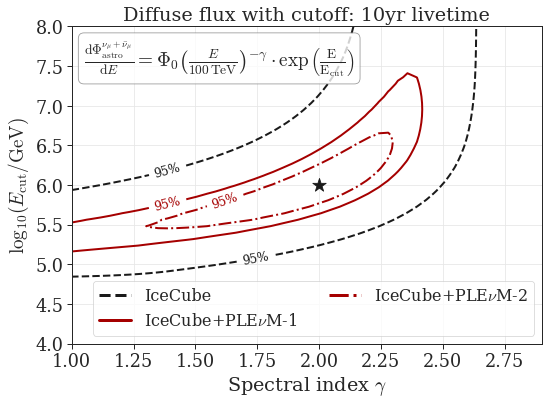

In [70]:
f, ax = plt.subplots(figsize=(8, 6))
cvals = [0.05]
lbs = ["95%"]
levels = chi2.isf(cvals, 2)
for ident in idents:
    # draw contour levels
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        lw=3,
        **contour_formats[ident],
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=12)

ax.scatter(
    bf_PLC["gamma"][ident], bf_PLC["cutoff"][ident], marker="*", s=200, color="k"
)
handles, _ = ax.get_legend_handles_labels()
handles.extend(
    [
        matplotlib.lines.Line2D(
            range(1),
            range(1),
            color=contour_formats["IceCube"]["colors"][0],
            ls=contour_formats["IceCube"]["linestyles"],
            lw=3,
            label="IceCube",
        ),
        matplotlib.lines.Line2D(
            range(1),
            range(1),
            color=contour_formats["Plenum-1"]["colors"][0],
            ls=contour_formats["Plenum-1"]["linestyles"],
            lw=3,
            label=r"IceCube+PLE$\nu$M-1",
        ),
        matplotlib.lines.Line2D(
            range(1),
            range(1),
            color=contour_formats["Plenum-2"]["colors"][0],
            ls=contour_formats["Plenum-2"]["linestyles"],
            lw=3,
            label=r"IceCube+PLE$\nu$M-2",
        ),
    ]
)
ax.legend(handles=handles, loc=4, ncol=2, fontsize="small")
ax.set_ylim(4.0, 8)
flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 100\,TeV} \right)^{-\gamma}"
flux_str += r" \cdot \exp \left( \frac{E}{E_{\rm cut}}\right)$"
ax.text(
    1.05,
    7.5,
    flux_str,
    fontsize="medium",
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
)
ax.set_ylabel(r"$\log_{10}(E_{\rm cut} / {\rm GeV})$")
ax.set_xlabel(r"Spectral index $\gamma$")
ax.set_title("Diffuse flux with cutoff: 10yr livetime")
f.tight_layout()
f.savefig(f"../plots/2D_scan_diffuse_pl-cut_comparison_gamma-cut.pdf")


IceCube
Plenum-1
Plenum-2


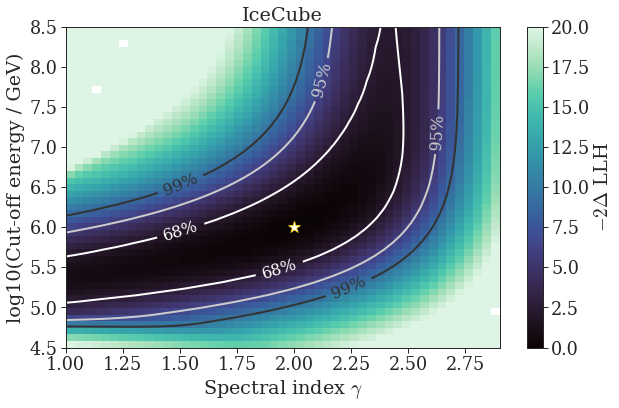

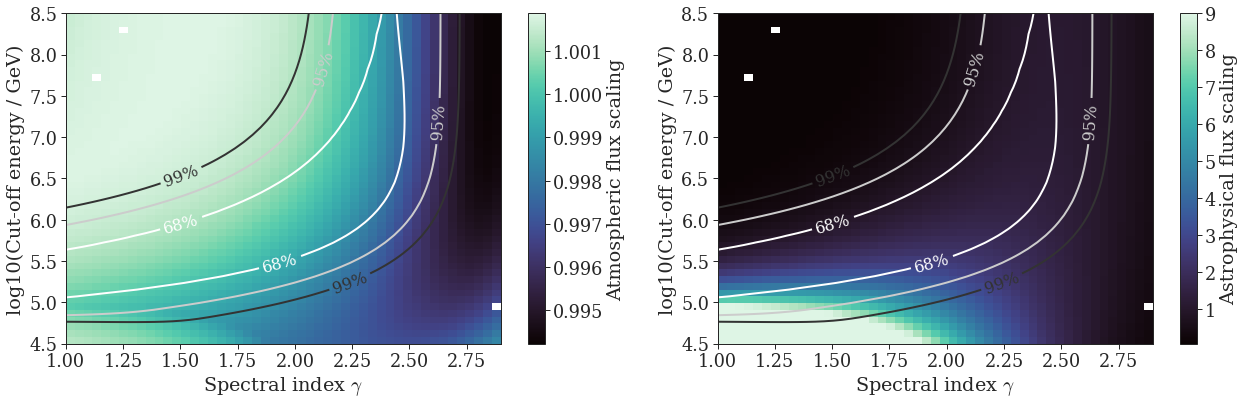

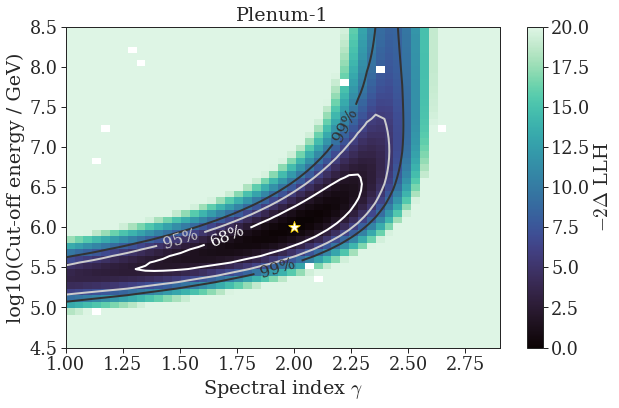

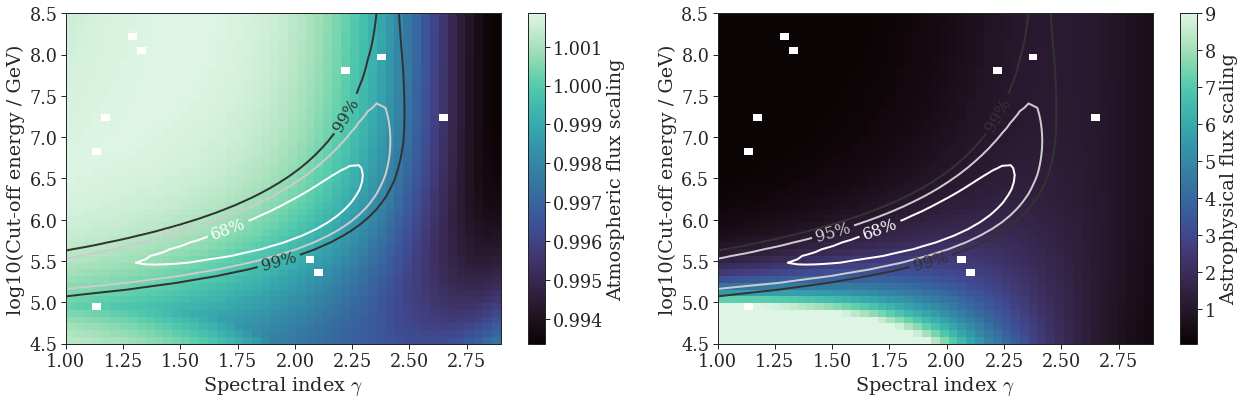

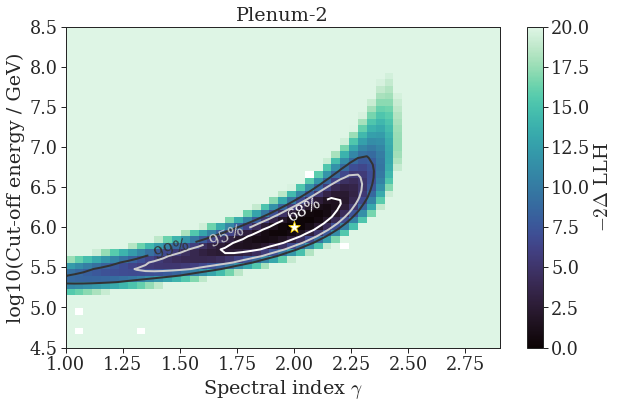

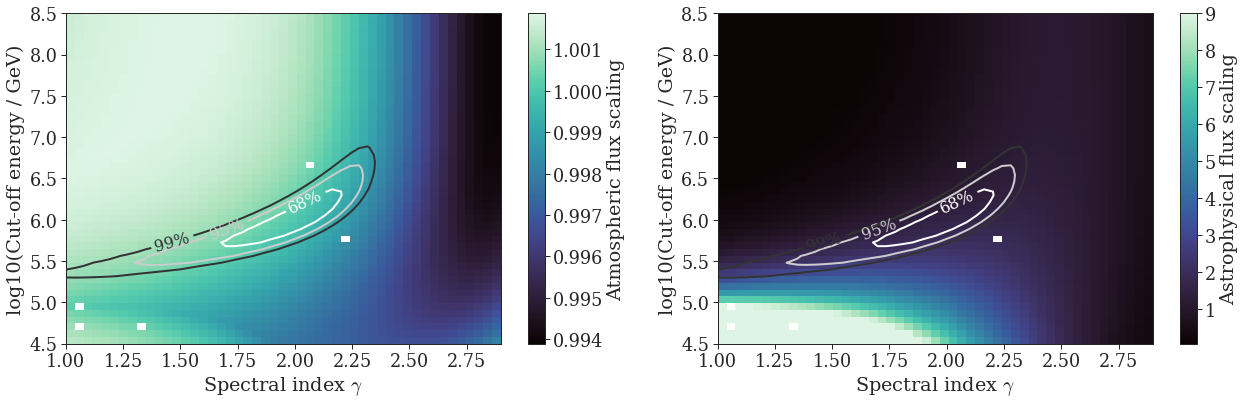

In [71]:
### white pixels are failed fits
for ident in idents:
    print(ident)
    ### plotting ###
    f, ax = plt.subplots(figsize=(9, 6))
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        vmin=0,
        vmax=20,
    )
    cb = plt.colorbar(im, ax=ax)

    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"],
    )
    ax.scatter(
        bf_PLC["gamma"][ident],
        bf_PLC["cutoff"][ident],
        marker="*",
        s=150,
        color="white",
        edgecolor="gold",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)

    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    f.tight_layout()
    f.savefig(f"../plots/2D_scan_diffuse_pl-cut_{ident}.pdf")

    f2, ax2 = plt.subplots(ncols=2, figsize=(18, 6))
    ## in addition, check the nuisance parameter of conventional flux
    ax = ax2[0]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["conv"][ident],
        # vmin=0.99,
    )

    ## add contours as reference
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"],
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")
    f.tight_layout()

    ax = ax2[1]
    im2 = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["phi_astro"][ident],
        # vmin=0.99,
    )
    ## add contours as reference
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"],
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im2, ax=ax)
    cb.set_label(r"Astrophysical flux scaling")
    f2.tight_layout()


# Cutoff significance versus time/detectors

Some options:
* 10yr IceCube
* 20yr IceCube
* 40yr IceCube
* 10yr IceCube + K3N
* 10yr IceCube + K3N + GVD
* 10yr IceCube + K3N + GVD + PONE
* 10yr IceCube +  2yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  5yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube + 10yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  2yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube +  5yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube + 10yr Plenum-2 (= GEN2 + PONE + GVD + K3N)

In [72]:
# livetime relative to 10yrs
detector_configurations = [
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 0,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC",
    },
    {
        "IceCube": 2.0,
        "Gen-2": 0,
        "Plenum-1": 0,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "20y IC",
    },
    {
        "IceCube": 4.0,
        "Gen-2": 0,
        "Plenum-1": 0,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "40y IC",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 0.2,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC + 2y PL-1",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 0.5,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC + 5y PL-1",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 1,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC + 10y PL-1",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0.2,
        "Plenum-1": 0,
        "KM3NeT": 0.2,
        "P-ONE": 0.2,
        "Baikal-GVD": 0.2,
        "identifier": "10y IC + 2y PL-2",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0.5,
        "Plenum-1": 0,
        "KM3NeT": 0.5,
        "P-ONE": 0.5,
        "Baikal-GVD": 0.5,
        "identifier": "10y IC + 5y PL-2",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 1,
        "Plenum-1": 0,
        "KM3NeT": 1,
        "P-ONE": 1,
        "Baikal-GVD": 1,
        "identifier": "10y IC + 10y PL-2",
    },
]
detector_configurations = pd.DataFrame(detector_configurations)


In [73]:
pvals = []
shape = "powerlaw with cutoff"

for idx, series in detector_configurations.iterrows():
    print(idx)
    aeff_factor = np.zeros_like(aeff_2d["IceCube"].T)
    naming = ""
    for ident, lt_factor in series.items():
        if ident == "identifier":
            continue
        if lt_factor == 0:
            continue
        print(ident)
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width)
            * LIVETIME
            * lt_factor
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape),
    )
    # check that the TS at the fit minimum is close to the TS of the baseline params
    baseline_ts_check = np.isclose(
        out[1],
        spectral_ts_func(
            shape_params[shape]["baseline"], aeff_factor, emids, E_NORM, k_i, shape
        ),
        rtol=1e-2,
    )
    print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
    # best fit powerlaw as null hypothesis
    out_pl = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params["powerlaw"]["guess"],
        bounds=shape_params["powerlaw"]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, "powerlaw"),
    )
    pval = chi2.sf(out_pl[1] - out[1], 1)
    sigma = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, ", SIGNIFICANCE:", sigma)
    pvals.append(
        {
            "identifier": series.identifier,  # str(idx) + ", " +
            "idx": idx,
            "pval": pval,
            r"Significance in $\sigma$": sigma,
        }
    )

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)


0
IceCube
TS asimov check: OK
P-VALUE: 0.12926413859452204 , SIGNIFICANCE: 1.5170100819432395
1
IceCube
TS asimov check: OK
P-VALUE: 0.031922773434605145 , SIGNIFICANCE: 2.145376287557094
2
IceCube
TS asimov check: OK
P-VALUE: 0.0024135271016717578 , SIGNIFICANCE: 3.0339771492975123
3
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.0446249353123437 , SIGNIFICANCE: 2.008172771993524
4
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.01081084350412457 , SIGNIFICANCE: 2.5487543030802597
5
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.0008556532772905443 , SIGNIFICANCE: 3.3341343183502112
6
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 0.008165339636952295 , SIGNIFICANCE: 2.6451554487693167
7
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 0.0001775712750388557 , SIGNIFICANCE: 3.7489573532579943
8
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 3.746315740516544e-07 , SIGNIFICANCE: 5.0814160494699


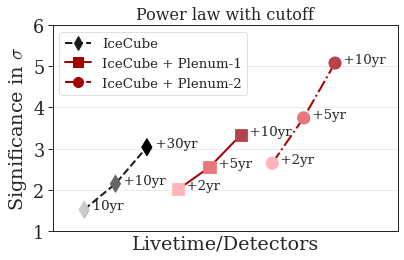

In [76]:
### plot significance vs livetime/detector configs
f, ax = plt.subplots()
label_size = "x-small"
# ICECUBE
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"],
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
    marker="d",
    label="IceCube",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"],
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    c=many_colors[:3],
    s=150,
    zorder=10,
    marker="d",
)
ax.text(
    x=pval_df.loc[0]["identifier"],
    y=pval_df.loc[0][r"Significance in $\sigma$"],
    s="  10yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[1]["identifier"],
    y=pval_df.loc[1][r"Significance in $\sigma$"],
    s="  +10yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[2]["identifier"],
    y=pval_df.loc[2][r"Significance in $\sigma$"],
    s="  +30yr",
    fontsize=label_size,
)

## PLENUM-1
ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"],
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
    marker="s",
    label="IceCube + Plenum-1",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"],
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="s",
)
ax.text(
    x=pval_df.loc[3]["identifier"],
    y=pval_df.loc[3][r"Significance in $\sigma$"],
    s="  +2yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[4]["identifier"],
    y=pval_df.loc[4][r"Significance in $\sigma$"],
    s="  +5yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[5]["identifier"],
    y=pval_df.loc[5][r"Significance in $\sigma$"],
    s="  +10yr",
    fontsize=label_size,
)


## PLENUM-2
ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"],
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
    marker="o",
    label="IceCube + Plenum-2",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"],
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="o",
)
ax.text(
    x=pval_df.loc[6]["identifier"],
    y=pval_df.loc[6][r"Significance in $\sigma$"],
    s="  +2yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[7]["identifier"],
    y=pval_df.loc[7][r"Significance in $\sigma$"],
    s="  +5yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[8]["identifier"],
    y=pval_df.loc[8][r"Significance in $\sigma$"],
    s="  +10yr",
    fontsize=label_size,
)

ax.set_xlim(-1, 10)
ax.set_ylim(1, 6)
ax.set_xticks([])
ax.legend(fontsize="x-small")
ax.set_title("Power law with cutoff", fontsize="small")
ax.set_xlabel("Livetime/Detectors")
ax.set_ylabel(r"Significance in $\sigma$")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det_talk.pdf")


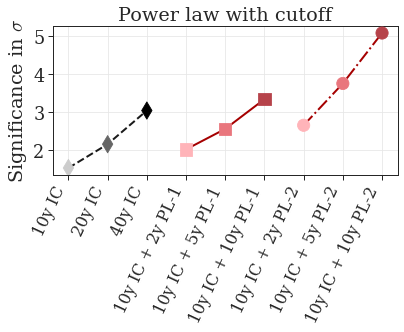

In [78]:
# same plot, alternative labeling as in PoS(ICRC2021)1185
f, ax = plt.subplots(figsize=(6, 5))

ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"],
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"],
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    c=many_colors[:3],
    s=150,
    zorder=10,
    marker="d",
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"],
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"],
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="s",
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"],
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"],
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="o",
)


# ax.set_ylim(0, 5.5)
ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"Significance in $\sigma$")
plt.xticks(rotation=65, fontsize="small", ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det.pdf")


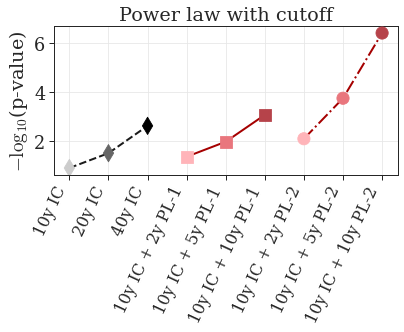

In [79]:
f, ax = plt.subplots(figsize=(6, 5))
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"],
    pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"],
    y=pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"],
    c=many_colors[:3],
    s=150,
    zorder=10,
    marker="d",
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"],
    pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"],
    y=pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="s",
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"],
    pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"],
    y=pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="o",
)

ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"$-\log_{10}$(p-value)")
plt.xticks(rotation=65, fontsize="small", ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_det.pdf")


## Significance vs cutoff value

In [80]:
print_names = {
    "IceCube": "IceCube",
    "Plenum-1": r"IceCube + PLE$\nu$M-1",
    "Plenum-2": r"IceCube + PLE$\nu$M-2",
}


In [81]:
pvals = []
cutoff_vals = np.round(np.arange(5.0, 8.1, step=0.2), 1)
for e_cut in cutoff_vals:
    for li, ident in enumerate(idents):
        shape = "powerlaw with cutoff"
        aeff_factor = (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        )
        if "Plenum" in ident:
            aeff_factor += (
                aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
                * LIVETIME
            )
        # asimov = expectation of perfect experiment
        shp_params = np.copy(shape_params[shape]["baseline"])
        shp_params[-1] = e_cut
        k_i = asimov_data(aeff_factor, shape, verbose=False, shp_params=shp_params)

        # global min
        out = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params[shape]["guess"],
            bounds=shape_params[shape]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, shape),
        )
        # check that the TS at the fit minimum is close to the TS of the baseline params
        reference = spectral_ts_func(shp_params, aeff_factor, emids, E_NORM, k_i, shape)
        baseline_ts_check = np.isclose(out[1], reference, rtol=1e-2)
        print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
        if not baseline_ts_check:
            print("e_cut:", shp_params[-1])
            print("fit: ", out[1], ", reference:", reference)
        # best fit powerlaw as null hypothesis
        out_pl = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params["powerlaw"]["guess"],
            bounds=shape_params["powerlaw"]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, "powerlaw"),
        )
        pval = chi2.sf(out_pl[1] - out[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        # print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)
        pvals.append(
            {
                "ident": print_names[ident],
                "pval": pval,
                r"Significance in $\sigma$": significance,
                r"$\log_{10}(E_{\rm cut}/{\rm GeV})$": e_cut,
                r"Conv_PL": out_pl[0][0],
                r"$\gamma_{PL}$": out_pl[0][1],
                r"$\Phi_{0,PL}$": out_pl[0][2],
                r"Conv": out[0][0],
                r"$\gamma$": out[0][1],
                r"$\Phi_{0}$": out[0][2],
                r"$E_{\rm cut}$": out[0][3],
            }
        )

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)


TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK


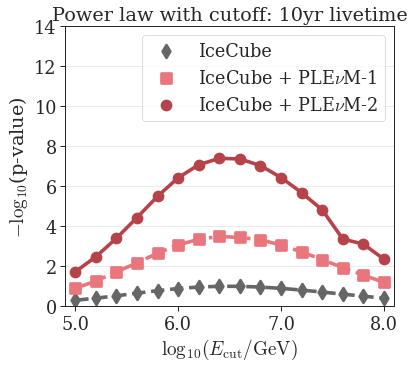

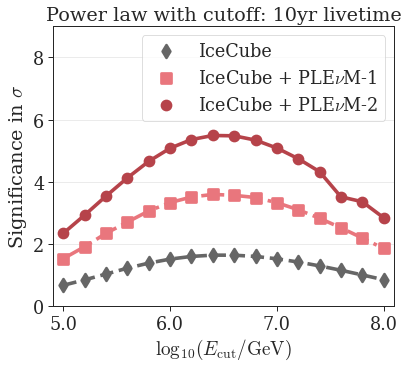

In [95]:
f, ax = plt.subplots(figsize=(6, 5.5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$-\log_{10}$(p-value)",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 5]],
    linestyles=["--", "-.", "-"],
    markers=["d", "s", "o"],
)
ax.set_title("Power law with cutoff: 10yr livetime")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1)  # , fontsize="x-small")
ax.set_ylim(0, 14)
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_cutoff.pdf")

f, ax = plt.subplots(figsize=(6, 5.5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"Significance in $\sigma$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 5]],
    linestyles=["--", "-.", "-"],
    markers=["d", "s", "o"],
)
ax.set_title("Power law with cutoff: 10yr livetime")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1)  # , fontsize="x-small")
ax.set_ylim(0, 9)
f.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_cutoff.pdf")


## check that parameter fits are ok

In [92]:
plot_kw = dict(
    palette=many_colors[[1, 4, 5]],
    linestyles=["-", "-.", "-"],
    markers=["d", "s", "o"],
)


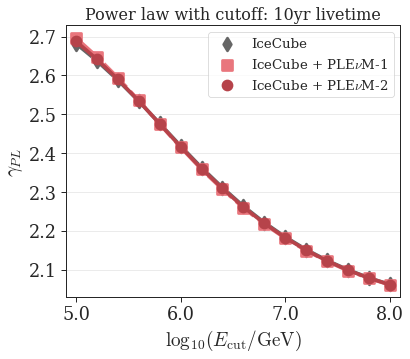

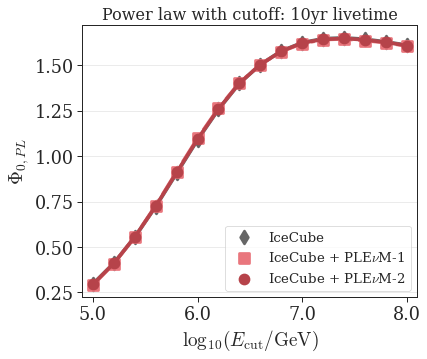

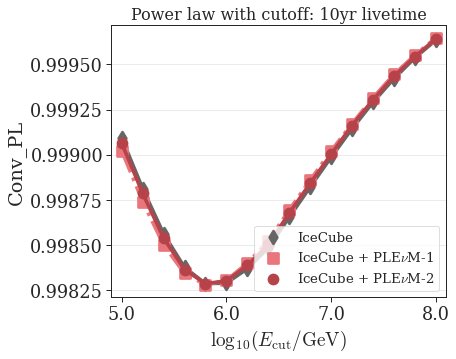

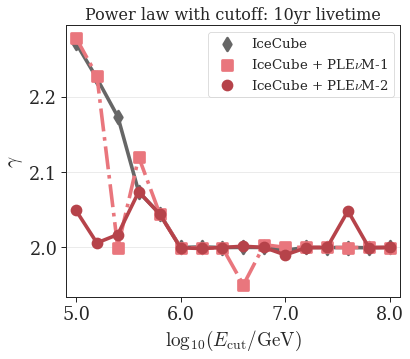

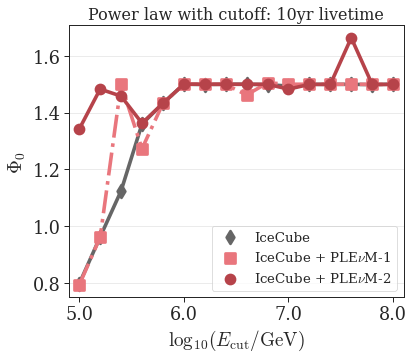

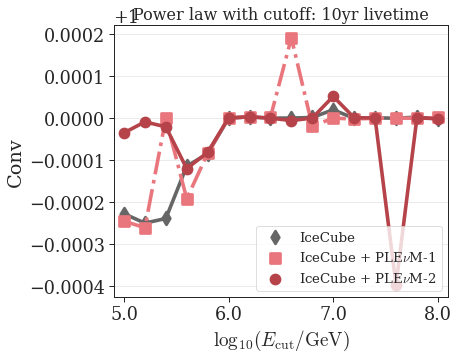

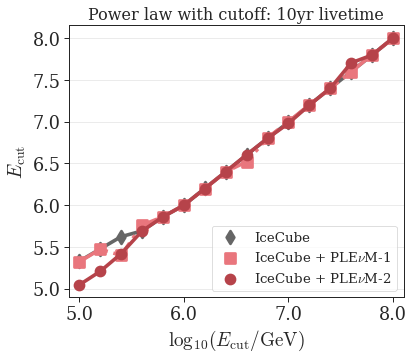

In [93]:
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\gamma_{PL}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\Phi_{0,PL}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"Conv_PL",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\gamma$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\Phi_{0}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"Conv",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$E_{\rm cut}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")
